# PV flux reconstruction.

In [2]:
# load modules 

import numpy as np
import xarray as xr
from xmitgcm import open_mdsdataset
from matplotlib import pyplot as plt
from matplotlib import colors, ticker, cm
from matplotlib.colors import LogNorm
%matplotlib inline
from funcs import *
from xgcm import Grid


In [5]:
Lcoarse = 50e3

diff_tensor = xr.open_dataset('./outputs_ncfiles/diff_tensor_'+str(int(Lcoarse//1e3))+'km.nc')
diff_tensor_2D = xr.open_dataset('./outputs_ncfiles/diff_tensor_2D_'+str(int(Lcoarse//1e3))+'km.nc')

Trac_coarse = xr.open_dataset('./outputs_ncfiles/Trac_coarse_'+str(int(Lcoarse//1e3))+'km.nc')
Vels_coarse = xr.open_dataset('./outputs_ncfiles/Vels_coarse_'+str(int(Lcoarse//1e3))+'km')
T_coarse    = xr.open_dataset('./outputs_ncfiles/T_coarse_'+str(int(Lcoarse//1e3))+'km')
Model_Tav = xr.open_dataset('./outputs_ncfiles/Model_Tav.nc')

In [6]:
grid = Grid(Model_Tav, periodic='X')

In [7]:
list_trac = ['TRAC01', 'TRAC02', 'TRAC03', 'TRAC04', 'TRAC05', 
            'TRAC06', 'TRAC07', 'TRAC08', 'TRAC09', 'TRAC10', 
            'TRAC11', 'TRAC12', 'TRAC13', 'TRAC14', 'TRAC15', 
            'TRAC16', 'TRAC17', 'TRAC18', 'TRAC19', 'TRAC20']
[UpCp, VpCp, WpCp] = get_flux_arrays(Trac_coarse, list_trac)
[dCdx, dCdy, dCdz]= get_grad_arrays(Trac_coarse, list_trac)

In [8]:
flux = xr.Dataset({'UpCp':UpCp, 'VpCp':VpCp, 'WpCp':WpCp})
grads = xr.Dataset({'dCdx':dCdx, 'dCdy':dCdy, 'dCdz':dCdz})

fluxT = xr.Dataset({'UpCp':T_coarse.UpTp, 'VpCp':T_coarse.VpTp, 'WpCp':T_coarse.WpTp})
gradT = xr.Dataset({'dCdx':T_coarse.T_X, 'dCdy':T_coarse.T_Y, 'dCdz':T_coarse.T_Z})

In [10]:
# Reconstruct flux using the gradients, and different tensors.
flux_rec_corr = flux_reconstruct(diff_tensor.Kcorr, flux, grads)
flux_rec_buoy = flux_reconstruct(diff_tensor.Kcorr, fluxT, gradT)
flux_rec_buoy_ST = flux_reconstruct(diff_tensor.STcorr, fluxT, gradT)
flux_rec_buoy_AT = flux_reconstruct(diff_tensor.ATcorr, fluxT, gradT)

In [11]:
# Extract axis for plotting
Xcoarse = T_coarse.XCcoarse
Ycoarse = T_coarse.YCcoarse
Z = T_coarse.Z

In [12]:
Model_Tav['UmeanC'] = grid.interp(Model_Tav.uVeltave, 'X')
Model_Tav['VmeanC'] = grid.interp(Model_Tav.vVeltave, 'Y', boundary='extend')
Model_Tav['WmeanC'] = grid.interp(Model_Tav.wVeltave, 'Z', boundary='extend')

# PV fluxes from model (raw fluxes)

\begin{equation}
\mathbf{u}q = \mathbf{u} \zeta + \frac{d}{dz} (\frac{f_o}{N^2} \mathbf{u} b) - \frac{\hat{k}}{N^2} \times \nabla (b^2)
\end{equation}


In [16]:
# no spatial averaging
upvp = grid.interp(grid.interp(Model_Tav.UVtave , 'X'), 'Y', boundary='extend') \
                   - Model_Tav.UmeanC*Model_Tav.VmeanC
vpvp = grid.interp(Model_Tav.VVtave, 'Y', boundary='extend')  - Model_Tav.VmeanC**2
upup = grid.interp(Model_Tav.UUtave, 'X') - Model_Tav.UmeanC**2

uptp = grid.interp(Model_Tav.UTtave,'X') - Model_Tav.UmeanC*Model_Tav.Ttave
vptp = grid.interp(Model_Tav.VTtave,'Y', boundary='extend') - Model_Tav.VmeanC*Model_Tav.Ttave

tptp = Model_Tav.TTtave - Model_Tav.Ttave**2

N2 = -grid.interp(grid.diff(Model_Tav.Ttave, 'Z', boundary='extend'), 
                 'Z', boundary='extend')/Model_Tav.drF

In [96]:
dx = 5e3
dy = 5e3

g=9.81
alpha=2e-4
f0= -1.1e-4 
beta = 1.4e-11

# upqp

# vorticity terms 
upqp1 =  grid.interp(grid.diff(upvp, 'X')/dx ,'X')

upqp2 = 0.5*grid.interp( grid.diff(vpvp -upup, 'Y', boundary='extend')/dy, 
                    'Y', boundary='extend')

# Rotational term 
upqp3 = 0.5*g*alpha/N2*grid.interp(grid.diff(tptp, 'Y', boundary='extend')/dy,
                          'Y', boundary='extend')

# b flux term
upqp4 = -f0*grid.interp( grid.diff(uptp/N2 ,'Z', boundary='extend'),
                      'Z', boundary='extend')/Model_Tav.drF
upqp = upqp1 + upqp2 + upqp3 + upqp4

# vpqp
# vorticity terms
vpqp1 = 0.5*grid.interp( grid.diff(vpvp -upup, 'X')/dx,'X')
vpqp2 = -0.5*g*alpha/N2*grid.interp(grid.diff(tptp, 'X')/dx,'X')
# Rotational term
vpqp3 = -grid.interp(grid.diff(upvp, 'Y', boundary='extend')/dy ,
                      'Y', boundary='extend')
# b flux term
vpqp4 = -f0*grid.interp( grid.diff(vptp/N2 ,'Z', boundary='extend'),
                      'Z', boundary='extend')/Model_Tav.drF
vpqp = vpqp1 + vpqp2 + vpqp3 + vpqp4

/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/xgcm/grid.py:1005: RuntimeWarning: invalid value encountered in subtract
  return data_right - data_left
/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/xgcm/grid.py:1001: RuntimeWarning: invalid value encountered in add
  return 0.5*(data_left + data_right)
/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/xgcm/grid.py:1005: RuntimeWarning: invalid value encountered in subtract
  return data_right - data_left
/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/xgcm/grid.py:1001: RuntimeWarning: invalid value encountered in add
  return 0.5*(data_left + data_right)


In [97]:
PV_fluxes = xr.Dataset()

In [98]:
PV_fluxes['upqp1'] = upqp1
PV_fluxes['upqp2'] = upqp2
PV_fluxes['upqp3'] = upqp3
PV_fluxes['upqp4'] = upqp4

PV_fluxes['vpqp1'] = vpqp1
PV_fluxes['vpqp2'] = vpqp2
PV_fluxes['vpqp3'] = vpqp3
PV_fluxes['vpqp4'] = vpqp4

In [99]:
# Spatial average PV fluxes 
Lcoarse = 50e3 # needs to be a multiple of the domain size.
idmax   = int( (Model_Tav.dyC[0,0].values * len(Model_Tav.YC))/Lcoarse) # numper of grid points to average over
nreps   = int( len(Model_Tav.YC)/idmax )

YCicoarse = np.repeat(range(idmax),nreps)
XCicoarse = np.repeat(range(idmax),nreps)

PV_fluxes.coords['XCicoarse'] = ('XC', XCicoarse)
PV_fluxes.coords['YCicoarse'] = ('YC', YCicoarse)
PV_fluxes.coords['hFacC'] = Model_Tav.hFacC

YCcoarse = ('YCicoarse', PV_fluxes.YC.groupby('YCicoarse').mean('YC'))
XCcoarse = ('XCicoarse', PV_fluxes.XC.groupby('XCicoarse').mean('XC'))

PV_fluxes_coarse = xr.Dataset()

for key in PV_fluxes.keys():
    temp = (PV_fluxes[key].groupby('YCicoarse').mean('YC')).groupby('XCicoarse').mean('XC')
    
    temp_array = xr.DataArray(temp.data, coords = [temp.Z, YCcoarse, XCcoarse], 
                             dims = ['Z', 'YCcoarse', 'XCcoarse'])
    
    PV_fluxes_coarse[key+'_coarse'] = temp_array

    
hFacCcoarse = ((PV_fluxes.hFacC.groupby('YCicoarse').mean('YC')).groupby('XCicoarse').mean('XC'))
PV_fluxes_coarse.coords['hFacCcoarse'] = (['Z', 'YCcoarse', 'XCcoarse'], hFacCcoarse)

/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [100]:
X = Model_Tav.XC
Y = Model_Tav.YC
Z = Model_Tav.Z

In [101]:
params = {
   'axes.labelsize': 12,
   'font.size': 12,
   'legend.fontsize': 12,
   'xtick.labelsize': 12,
   'ytick.labelsize': 12,
   'text.usetex': False,
   'figure.figsize': [4.5, 4.5]
   }
plt.rcParams.update(params)

XY plots

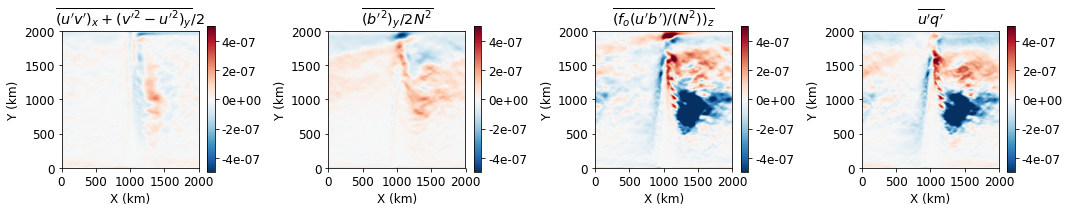

In [103]:
# u fluxes 
fig, ax = plt.subplots(1,4, figsize=(15,3))

im = ax[0].pcolormesh(X/1e3, Y/1e3, (upqp1 + upqp2).sel(Z=-1000, method='nearest') ,
                        vmin=-5e-7, vmax=5e-7, cmap='RdBu_r', rasterized=True)
ax[0].set_title('$\overline{(u\'v\')_x + (v\'^2 - u\'^2)_y}$/2 ')
ax[0].set_aspect('equal')
fig.colorbar(im, ax=ax[0], format='%.0e')
ax[0].set_xlabel('X (km)')
ax[0].set_ylabel('Y (km)')

im = ax[1].pcolormesh(X/1e3, Y/1e3, (upqp3).sel(Z=-1000, method='nearest') ,
                        vmin=-5e-7, vmax=5e-7, cmap='RdBu_r', rasterized=True)
ax[1].set_title('$\overline{(b\'^2)_y/2N^2}$')
ax[1].set_aspect('equal')
fig.colorbar(im, ax=ax[1], format='%.0e')
ax[1].set_xlabel('X (km)')
ax[1].set_ylabel('Y (km)')

im = ax[2].pcolormesh(X/1e3, Y/1e3, upqp4.sel(Z=-1000, method='nearest') ,
                        vmin=-5e-7, vmax=5e-7, cmap='RdBu_r', rasterized=True)
ax[2].set_title('$\overline{(f_o (u\'b\')/(N^2))_z}$')
ax[2].set_aspect('equal')
fig.colorbar(im, ax=ax[2], format='%.0e')
ax[2].set_xlabel('X (km)')
ax[2].set_ylabel('Y (km)')

im = ax[3].pcolormesh(X/1e3, Y/1e3, (upqp1 + upqp2 + upqp3 + upqp4).sel(Z=-1000, method='nearest') ,
                        vmin=-5e-7, vmax=5e-7, cmap='RdBu_r', rasterized=True)
ax[3].set_title('$\overline{u\'q\'}$')
ax[3].set_aspect('equal')
ax[3].set_xlabel('X (km)')
ax[3].set_ylabel('Y (km)')
fig.colorbar(im, ax=ax[3], format='%.0e')

plt.tight_layout()

plt.savefig('fig9a.pdf', dpi=200,bbox_inches='tight')

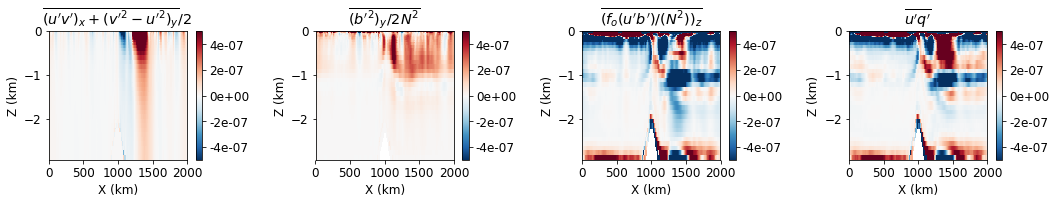

In [104]:
# u fluxes 
fig, ax = plt.subplots(1,4, figsize=(15,3))

im = ax[0].pcolormesh(X/1e3, Z/1e3, (upqp1 + upqp2).sel(YC=1000e3, method='nearest') ,
                        vmin=-5e-7, vmax=5e-7, cmap='RdBu_r', rasterized=True)
ax[0].set_title('$\overline{(u\'v\')_x + (v\'^2 - u\'^2)_y}$/2 ')
fig.colorbar(im, ax=ax[0], format='%.0e')
ax[0].set_xlabel('X (km)')
ax[0].set_ylabel('Z (km)')

im = ax[1].pcolormesh(X/1e3, Z/1e3, (upqp3).sel(YC=1000e3, method='nearest') ,
                        vmin=-5e-7, vmax=5e-7, cmap='RdBu_r', rasterized=True)
ax[1].set_title('$\overline{(b\'^2)_y/2N^2}$')
fig.colorbar(im, ax=ax[1], format='%.0e')
ax[1].set_xlabel('X (km)')
ax[1].set_ylabel('Z (km)')

im = ax[2].pcolormesh(X/1e3, Z/1e3, upqp4.sel(YC=1000e3, method='nearest') ,
                        vmin=-5e-7, vmax=5e-7, cmap='RdBu_r', rasterized=True)
ax[2].set_title('$\overline{(f_o (u\'b\')/(N^2))_z}$')
fig.colorbar(im, ax=ax[2], format='%.0e')
ax[2].set_xlabel('X (km)')
ax[2].set_ylabel('Z (km)')

im = ax[3].pcolormesh(X/1e3, Z/1e3, (upqp1 + upqp2 + upqp3 + upqp4).sel(YC=1000e3, method='nearest') ,
                        vmin=-5e-7, vmax=5e-7, cmap='RdBu_r', rasterized=True)
ax[3].set_title('$\overline{u\'q\'}$')
ax[3].set_xlabel('X (km)')
ax[3].set_ylabel('Z (km)')
fig.colorbar(im, ax=ax[3], format='%.0e')

plt.tight_layout()
plt.savefig('fig9b.pdf', dpi=200,bbox_inches='tight')

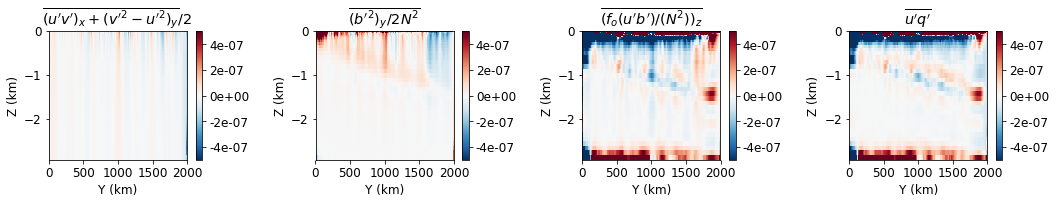

In [105]:
# u fluxes 
fig, ax = plt.subplots(1,4, figsize=(15,3))

im = ax[0].pcolormesh(X/1e3, Z/1e3, (upqp1 + upqp2).sel(XC=0e3, method='nearest') ,
                        vmin=-5e-7, vmax=5e-7, cmap='RdBu_r', rasterized=True)
ax[0].set_title('$\overline{(u\'v\')_x + (v\'^2 - u\'^2)_y}$/2 ')
fig.colorbar(im, ax=ax[0], format='%.0e')
ax[0].set_xlabel('Y (km)')
ax[0].set_ylabel('Z (km)')

im = ax[1].pcolormesh(X/1e3, Z/1e3, (upqp3).sel(XC=0e3, method='nearest') ,
                        vmin=-5e-7, vmax=5e-7, cmap='RdBu_r', rasterized=True)
ax[1].set_title('$\overline{(b\'^2)_y/2N^2}$')
fig.colorbar(im, ax=ax[1], format='%.0e')
ax[1].set_xlabel('Y (km)')
ax[1].set_ylabel('Z (km)')

im = ax[2].pcolormesh(X/1e3, Z/1e3, upqp4.sel(XC=0e3, method='nearest') ,
                        vmin=-5e-7, vmax=5e-7, cmap='RdBu_r', rasterized=True)
ax[2].set_title('$\overline{(f_o (u\'b\')/(N^2))_z}$')
fig.colorbar(im, ax=ax[2], format='%.0e')
ax[2].set_xlabel('Y (km)')
ax[2].set_ylabel('Z (km)')

im = ax[3].pcolormesh(X/1e3, Z/1e3, (upqp1 + upqp2 + upqp3 + upqp4).sel(XC=0e3, method='nearest') ,
                        vmin=-5e-7, vmax=5e-7, cmap='RdBu_r', rasterized=True)
ax[3].set_title('$\overline{u\'q\'}$')
ax[3].set_xlabel('Y (km)')
ax[3].set_ylabel('Z (km)')
fig.colorbar(im, ax=ax[3], format='%.0e')

plt.tight_layout()
plt.savefig('fig9c.pdf', dpi=200,bbox_inches='tight')

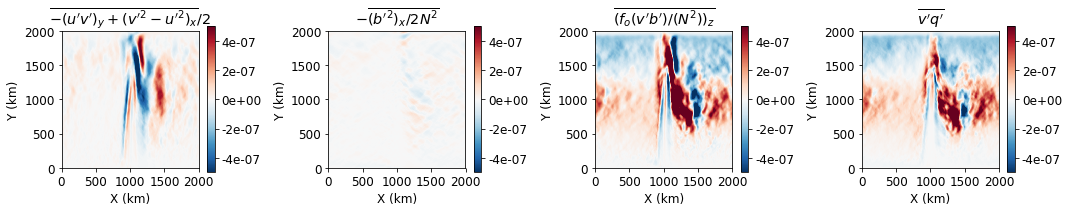

In [106]:
# u fluxes 
fig, ax = plt.subplots(1,4, figsize=(15,3))

im = ax[0].pcolormesh(X/1e3, Y/1e3, (vpqp1 + vpqp2).sel(Z=-1000, method='nearest') ,
                        vmin=-5e-7, vmax=5e-7, cmap='RdBu_r', rasterized=True)
ax[0].set_title('$\overline{-(u\'v\')_y + (v\'^2 - u\'^2)_x }$/2 ')
ax[0].set_aspect('equal')
fig.colorbar(im, ax=ax[0], format='%.0e')
ax[0].set_xlabel('X (km)')
ax[0].set_ylabel('Y (km)')

im = ax[1].pcolormesh(X/1e3, Y/1e3, (vpqp3).sel(Z=-1000, method='nearest') ,
                        vmin=-5e-7, vmax=5e-7, cmap='RdBu_r', rasterized=True)
ax[1].set_title('$-\overline{(b\'^2)_x/2N^2}$')
ax[1].set_aspect('equal')
fig.colorbar(im, ax=ax[1], format='%.0e')
ax[1].set_xlabel('X (km)')
ax[1].set_ylabel('Y (km)')

im = ax[2].pcolormesh(X/1e3, Y/1e3, vpqp4.sel(Z=-1000, method='nearest') ,
                        vmin=-5e-7, vmax=5e-7, cmap='RdBu_r', rasterized=True)
ax[2].set_title('$\overline{(f_o (v\'b\')/(N^2))_z}$')
ax[2].set_aspect('equal')
fig.colorbar(im, ax=ax[2], format='%.0e')
ax[2].set_xlabel('X (km)')
ax[2].set_ylabel('Y (km)')

im = ax[3].pcolormesh(X/1e3, Y/1e3, (vpqp1 + vpqp2 + vpqp3 + vpqp4).sel(Z=-1000, method='nearest') ,
                        vmin=-5e-7, vmax=5e-7, cmap='RdBu_r', rasterized=True)
ax[3].set_title('$\overline{v\'q\'}$')
ax[3].set_aspect('equal')
ax[3].set_xlabel('X (km)')
ax[3].set_ylabel('Y (km)')
fig.colorbar(im, ax=ax[3], format='%.0e')

plt.tight_layout()
plt.savefig('fig9d.pdf', dpi=200,bbox_inches='tight')

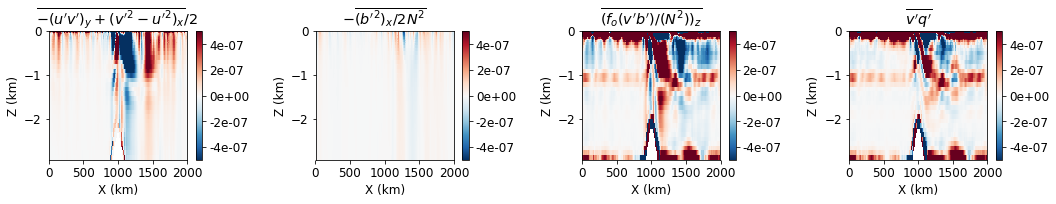

In [107]:
# u fluxes 
fig, ax = plt.subplots(1,4, figsize=(15,3))

im = ax[0].pcolormesh(X/1e3, Z/1e3, (vpqp1 + vpqp2).sel(YC=1000e3, method='nearest') ,
                        vmin=-5e-7, vmax=5e-7, cmap='RdBu_r', rasterized=True)
ax[0].set_title('$\overline{-(u\'v\')_y + (v\'^2 - u\'^2)_x }$/2 ')
fig.colorbar(im, ax=ax[0], format='%.0e')
ax[0].set_xlabel('X (km)')
ax[0].set_ylabel('Z (km)')

im = ax[1].pcolormesh(X/1e3, Z/1e3, (vpqp3).sel(YC=1000e3, method='nearest') ,
                        vmin=-5e-7, vmax=5e-7, cmap='RdBu_r', rasterized=True)
ax[1].set_title('$-\overline{(b\'^2)_x/2N^2}$')
fig.colorbar(im, ax=ax[1], format='%.0e')
ax[1].set_xlabel('X (km)')
ax[1].set_ylabel('Z (km)')

im = ax[2].pcolormesh(X/1e3, Z/1e3, vpqp4.sel(YC=1000e3, method='nearest') ,
                        vmin=-5e-7, vmax=5e-7, cmap='RdBu_r', rasterized=True)
ax[2].set_title('$\overline{(f_o (v\'b\')/(N^2))_z}$')
fig.colorbar(im, ax=ax[2], format='%.0e')
ax[2].set_xlabel('X (km)')
ax[2].set_ylabel('Z (km)')

im = ax[3].pcolormesh(X/1e3, Z/1e3, (vpqp1 + vpqp2 + vpqp3 + vpqp4).sel(YC=1000e3, method='nearest') ,
                        vmin=-5e-7, vmax=5e-7, cmap='RdBu_r', rasterized=True)
ax[3].set_title('$\overline{v\'q\'}$')
ax[3].set_xlabel('X (km)')
ax[3].set_ylabel('Z (km)')
fig.colorbar(im, ax=ax[3], format='%.0e')

plt.tight_layout()
plt.savefig('fig9e.pdf', dpi=200,bbox_inches='tight')

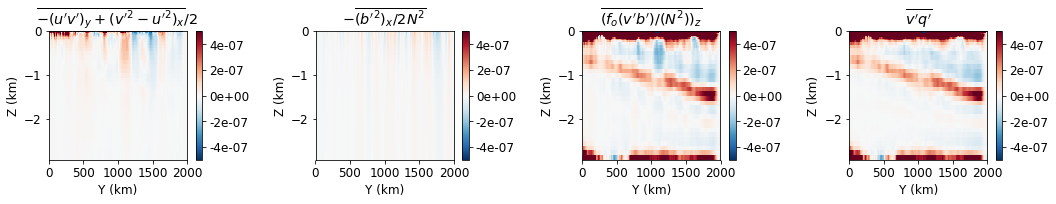

In [108]:
# u fluxes 
fig, ax = plt.subplots(1,4, figsize=(15,3))

im = ax[0].pcolormesh(X/1e3, Z/1e3, (vpqp1 + vpqp2).sel(XC=0e3, method='nearest') ,
                        vmin=-5e-7, vmax=5e-7, cmap='RdBu_r', rasterized=True)
ax[0].set_title('$\overline{-(u\'v\')_y + (v\'^2 - u\'^2)_x }$/2 ')
fig.colorbar(im, ax=ax[0], format='%.0e')
ax[0].set_xlabel('Y (km)')
ax[0].set_ylabel('Z (km)')

im = ax[1].pcolormesh(X/1e3, Z/1e3, (vpqp3).sel(XC=0e3, method='nearest') ,
                        vmin=-5e-7, vmax=5e-7, cmap='RdBu_r', rasterized=True)
ax[1].set_title('$-\overline{(b\'^2)_x/2N^2}$')
fig.colorbar(im, ax=ax[1], format='%.0e')
ax[1].set_xlabel('Y (km)')
ax[1].set_ylabel('Z (km)')

im = ax[2].pcolormesh(X/1e3, Z/1e3, vpqp4.sel(XC=0e3, method='nearest') ,
                        vmin=-5e-7, vmax=5e-7, cmap='RdBu_r', rasterized=True)
ax[2].set_title('$\overline{(f_o (v\'b\')/(N^2))_z}$')
fig.colorbar(im, ax=ax[2], format='%.0e')
ax[2].set_xlabel('Y (km)')
ax[2].set_ylabel('Z (km)')

im = ax[3].pcolormesh(X/1e3, Z/1e3, (vpqp1 + vpqp2 + vpqp3 + vpqp4).sel(XC=0e3, method='nearest') ,
                        vmin=-5e-7, vmax=5e-7, cmap='RdBu_r', rasterized=True)
ax[3].set_title('$\overline{v\'q\'}$')
ax[3].set_xlabel('Y (km)')
ax[3].set_ylabel('Z (km)')
fig.colorbar(im, ax=ax[3], format='%.0e')

plt.tight_layout()
plt.savefig('fig9f.pdf', dpi=200,bbox_inches='tight')

/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0, 0.5, 'PDF')

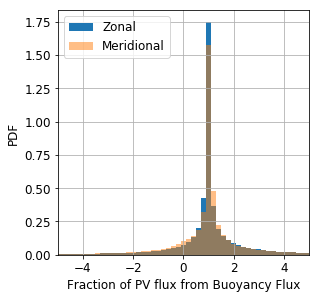

In [110]:
(vpqp4/vpqp).plot.hist(bins=np.linspace(-100, 100,1000), normed=True, label='Zonal')
(upqp4/upqp).plot.hist(bins=np.linspace(-100, 100,1000), normed=True, alpha=0.5, label='Meridional')

plt.grid()
plt.xlim([-5, 5])
plt.legend()
plt.title('')
plt.xlabel('Fraction of PV flux from Buoyancy Flux')
plt.ylabel('PDF')
#plt.savefig('hist_fraction_bflux.pdf',dpi=200,bbox_inches='tight')

/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0, 0.5, 'PDF')

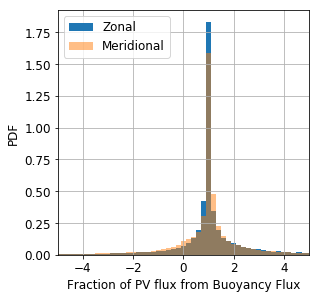

In [111]:
(PV_fluxes_coarse['vpqp4_coarse']/(
    PV_fluxes_coarse['vpqp1_coarse']+PV_fluxes_coarse['vpqp2_coarse']+PV_fluxes_coarse['vpqp3_coarse']+PV_fluxes_coarse['vpqp4_coarse'])
).where(PV_fluxes_coarse.hFacCcoarse==1).plot.hist(bins=np.linspace(-100, 100,1000), normed=True, label='Zonal')
(PV_fluxes_coarse['upqp4_coarse']/(
    PV_fluxes_coarse['upqp1_coarse']+PV_fluxes_coarse['upqp2_coarse']+PV_fluxes_coarse['upqp3_coarse']+PV_fluxes_coarse['upqp4_coarse'])
).where(PV_fluxes_coarse.hFacCcoarse==1).plot.hist(bins=np.linspace(-100, 100,1000), normed=True, alpha=0.5, label='Meridional')
#(upqp4/upqp).plot.hist(bins=np.linspace(-100, 100,1000), normed=True, alpha=0.5, label='Meridional')

plt.grid()
plt.xlim([-5, 5])
plt.legend()
plt.title('')
plt.xlabel('Fraction of PV flux from Buoyancy Flux')
plt.ylabel('PDF')
#plt.savefig('hist_fraction_bflux.pdf',dpi=200,bbox_inches='tight')

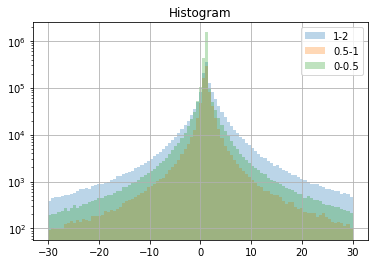

In [86]:
(vpqp4/vpqp).sel(Z=slice(-1000,-2000)).plot.hist(bins=np.linspace(-30, 30,100), alpha=0.3, label='1-2')
(vpqp4/vpqp).sel(Z=slice(-500,-1000)).plot.hist(bins=np.linspace(-30, 30,100), alpha=0.3, label='0.5-1')
(vpqp4/vpqp).sel(Z=slice(0,-500)).plot.hist(bins=np.linspace(-30, 30,100), alpha=0.3, label='0-0.5')

plt.yscale('log')
plt.grid()
plt.legend()


# coarse PV fluxes

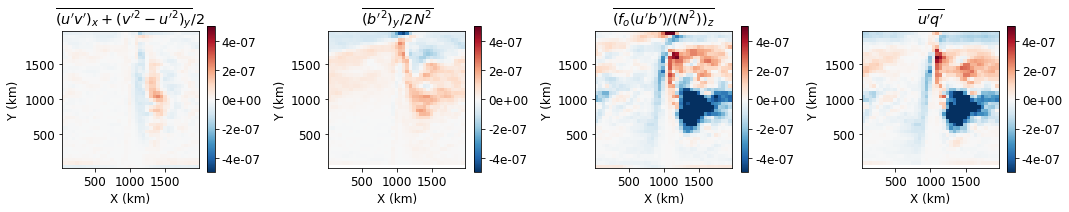

In [112]:
# u fluxes 
fig, ax = plt.subplots(1,4, figsize=(15,3))

im = ax[0].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, (PV_fluxes_coarse['upqp1_coarse'] + PV_fluxes_coarse['upqp2_coarse']).sel(Z=-1000, method='nearest') ,
                        vmin=-5e-7, vmax=5e-7, cmap='RdBu_r', rasterized=True)
ax[0].set_title('$\overline{(u\'v\')_x + (v\'^2 - u\'^2)_y}$/2 ')
ax[0].set_aspect('equal')
fig.colorbar(im, ax=ax[0], format='%.0e')
ax[0].set_xlabel('X (km)')
ax[0].set_ylabel('Y (km)')

im = ax[1].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, (PV_fluxes_coarse['upqp3_coarse']).sel(Z=-1000, method='nearest') ,
                        vmin=-5e-7, vmax=5e-7, cmap='RdBu_r', rasterized=True)
ax[1].set_title('$\overline{(b\'^2)_y/2N^2}$')
ax[1].set_aspect('equal')
fig.colorbar(im, ax=ax[1], format='%.0e')
ax[1].set_xlabel('X (km)')
ax[1].set_ylabel('Y (km)')

im = ax[2].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, PV_fluxes_coarse['upqp4_coarse'].sel(Z=-1000, method='nearest') ,
                        vmin=-5e-7, vmax=5e-7, cmap='RdBu_r', rasterized=True)
ax[2].set_title('$\overline{(f_o (u\'b\')/(N^2))_z}$')
ax[2].set_aspect('equal')
fig.colorbar(im, ax=ax[2], format='%.0e')
ax[2].set_xlabel('X (km)')
ax[2].set_ylabel('Y (km)')

im = ax[3].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, (PV_fluxes_coarse['upqp1_coarse']+PV_fluxes_coarse['upqp2_coarse']
                                     +PV_fluxes_coarse['upqp3_coarse']+PV_fluxes_coarse['upqp4_coarse']).sel(Z=-1000, method='nearest') ,
                        vmin=-5e-7, vmax=5e-7, cmap='RdBu_r', rasterized=True)
ax[3].set_title('$\overline{u\'q\'}$')
ax[3].set_aspect('equal')
ax[3].set_xlabel('X (km)')
ax[3].set_ylabel('Y (km)')
fig.colorbar(im, ax=ax[3], format='%.0e')

plt.tight_layout()

#plt.savefig('fig9a.pdf', dpi=200,bbox_inches='tight')

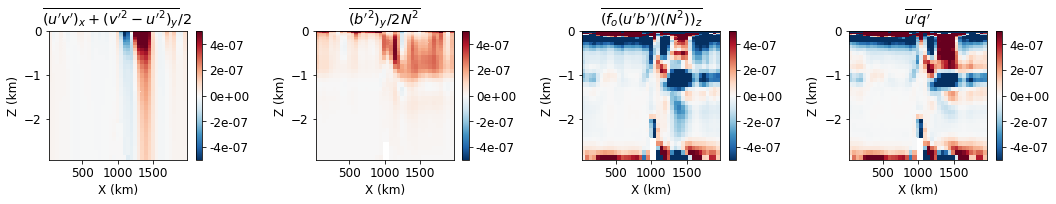

In [113]:
# u fluxes 
fig, ax = plt.subplots(1,4, figsize=(15,3))

im = ax[0].pcolormesh(Xcoarse/1e3, Z/1e3, (PV_fluxes_coarse['upqp1_coarse'] + PV_fluxes_coarse['upqp2_coarse']).sel(YCcoarse=1000e3, method='nearest') ,
                        vmin=-5e-7, vmax=5e-7, cmap='RdBu_r', rasterized=True)
ax[0].set_title('$\overline{(u\'v\')_x + (v\'^2 - u\'^2)_y}$/2 ')
fig.colorbar(im, ax=ax[0], format='%.0e')
ax[0].set_xlabel('X (km)')
ax[0].set_ylabel('Z (km)')

im = ax[1].pcolormesh(Xcoarse/1e3, Z/1e3, (PV_fluxes_coarse['upqp3_coarse']).sel(YCcoarse=1000e3, method='nearest') ,
                        vmin=-5e-7, vmax=5e-7, cmap='RdBu_r', rasterized=True)
ax[1].set_title('$\overline{(b\'^2)_y/2N^2}$')
fig.colorbar(im, ax=ax[1], format='%.0e')
ax[1].set_xlabel('X (km)')
ax[1].set_ylabel('Z (km)')

im = ax[2].pcolormesh(Xcoarse/1e3, Z/1e3, PV_fluxes_coarse['upqp4_coarse'].sel(YCcoarse=1000e3, method='nearest') ,
                        vmin=-5e-7, vmax=5e-7, cmap='RdBu_r', rasterized=True)
ax[2].set_title('$\overline{(f_o (u\'b\')/(N^2))_z}$')
fig.colorbar(im, ax=ax[2], format='%.0e')
ax[2].set_xlabel('X (km)')
ax[2].set_ylabel('Z (km)')

im = ax[3].pcolormesh(Xcoarse/1e3, Z/1e3, (PV_fluxes_coarse['upqp1_coarse'] + PV_fluxes_coarse['upqp2_coarse'] + 
                                     PV_fluxes_coarse['upqp3_coarse'] + PV_fluxes_coarse['upqp4_coarse']).sel(YCcoarse=1000e3, method='nearest') ,
                        vmin=-5e-7, vmax=5e-7, cmap='RdBu_r', rasterized=True)
ax[3].set_title('$\overline{u\'q\'}$')
ax[3].set_xlabel('X (km)')
ax[3].set_ylabel('Z (km)')
fig.colorbar(im, ax=ax[3], format='%.0e')

plt.tight_layout()
#plt.savefig('fig9b.pdf', dpi=200,bbox_inches='tight')

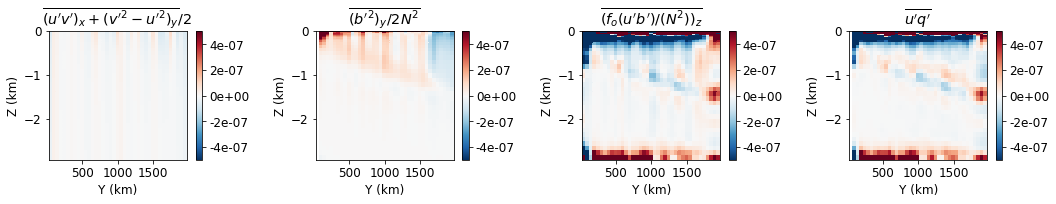

In [114]:
# u fluxes 
fig, ax = plt.subplots(1,4, figsize=(15,3))

im = ax[0].pcolormesh(Xcoarse/1e3, Z/1e3, (PV_fluxes_coarse['upqp1_coarse'] + PV_fluxes_coarse['upqp2_coarse']).sel(XCcoarse=0e3, method='nearest') ,
                        vmin=-5e-7, vmax=5e-7, cmap='RdBu_r', rasterized=True)
ax[0].set_title('$\overline{(u\'v\')_x + (v\'^2 - u\'^2)_y}$/2 ')
fig.colorbar(im, ax=ax[0], format='%.0e')
ax[0].set_xlabel('Y (km)')
ax[0].set_ylabel('Z (km)')

im = ax[1].pcolormesh(Xcoarse/1e3, Z/1e3, (PV_fluxes_coarse['upqp3_coarse']).sel(XCcoarse=0e3, method='nearest') ,
                        vmin=-5e-7, vmax=5e-7, cmap='RdBu_r', rasterized=True)
ax[1].set_title('$\overline{(b\'^2)_y/2N^2}$')
fig.colorbar(im, ax=ax[1], format='%.0e')
ax[1].set_xlabel('Y (km)')
ax[1].set_ylabel('Z (km)')

im = ax[2].pcolormesh(Xcoarse/1e3, Z/1e3, PV_fluxes_coarse['upqp4_coarse'].sel(XCcoarse=0e3, method='nearest') ,
                        vmin=-5e-7, vmax=5e-7, cmap='RdBu_r', rasterized=True)
ax[2].set_title('$\overline{(f_o (u\'b\')/(N^2))_z}$')
fig.colorbar(im, ax=ax[2], format='%.0e')
ax[2].set_xlabel('Y (km)')
ax[2].set_ylabel('Z (km)')

im = ax[3].pcolormesh(Xcoarse/1e3, Z/1e3, (PV_fluxes_coarse['upqp1_coarse'] + PV_fluxes_coarse['upqp2_coarse'] +
                                     PV_fluxes_coarse['upqp3_coarse'] + PV_fluxes_coarse['upqp4_coarse']).sel(XCcoarse=0e3, method='nearest') ,
                        vmin=-5e-7, vmax=5e-7, cmap='RdBu_r', rasterized=True)
ax[3].set_title('$\overline{u\'q\'}$')
ax[3].set_xlabel('Y (km)')
ax[3].set_ylabel('Z (km)')
fig.colorbar(im, ax=ax[3], format='%.0e')

plt.tight_layout()
#plt.savefig('fig9c.pdf', dpi=200,bbox_inches='tight')

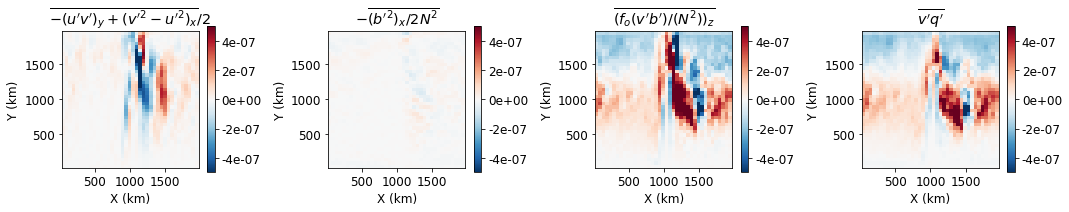

In [115]:
# u fluxes 
fig, ax = plt.subplots(1,4, figsize=(15,3))

im = ax[0].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, (PV_fluxes_coarse['vpqp1_coarse'] + PV_fluxes_coarse['vpqp2_coarse']).sel(Z=-1000, method='nearest') ,
                        vmin=-5e-7, vmax=5e-7, cmap='RdBu_r', rasterized=True)
ax[0].set_title('$\overline{-(u\'v\')_y + (v\'^2 - u\'^2)_x }$/2 ')
ax[0].set_aspect('equal')
fig.colorbar(im, ax=ax[0], format='%.0e')
ax[0].set_xlabel('X (km)')
ax[0].set_ylabel('Y (km)')

im = ax[1].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, (PV_fluxes_coarse['vpqp3_coarse']).sel(Z=-1000, method='nearest') ,
                        vmin=-5e-7, vmax=5e-7, cmap='RdBu_r', rasterized=True)
ax[1].set_title('$-\overline{(b\'^2)_x/2N^2}$')
ax[1].set_aspect('equal')
fig.colorbar(im, ax=ax[1], format='%.0e')
ax[1].set_xlabel('X (km)')
ax[1].set_ylabel('Y (km)')

im = ax[2].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, PV_fluxes_coarse['vpqp4_coarse'].sel(Z=-1000, method='nearest') ,
                        vmin=-5e-7, vmax=5e-7, cmap='RdBu_r', rasterized=True)
ax[2].set_title('$\overline{(f_o (v\'b\')/(N^2))_z}$')
ax[2].set_aspect('equal')
fig.colorbar(im, ax=ax[2], format='%.0e')
ax[2].set_xlabel('X (km)')
ax[2].set_ylabel('Y (km)')

im = ax[3].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, (PV_fluxes_coarse['vpqp1_coarse']+PV_fluxes_coarse['vpqp2_coarse']
                                     +PV_fluxes_coarse['vpqp3_coarse']+PV_fluxes_coarse['vpqp4_coarse']).sel(Z=-1000, method='nearest') ,
                        vmin=-5e-7, vmax=5e-7, cmap='RdBu_r', rasterized=True)
ax[3].set_title('$\overline{v\'q\'}$')
ax[3].set_aspect('equal')
ax[3].set_xlabel('X (km)')
ax[3].set_ylabel('Y (km)')
fig.colorbar(im, ax=ax[3], format='%.0e')

plt.tight_layout()

#plt.savefig('fig9a.pdf', dpi=200,bbox_inches='tight')

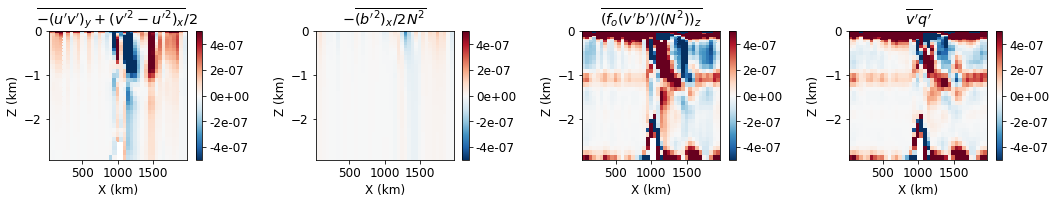

In [116]:
# u fluxes 
fig, ax = plt.subplots(1,4, figsize=(15,3))

im = ax[0].pcolormesh(Xcoarse/1e3, Z/1e3, (PV_fluxes_coarse['vpqp1_coarse'] + PV_fluxes_coarse['vpqp2_coarse']).sel(YCcoarse=1000e3, method='nearest') ,
                        vmin=-5e-7, vmax=5e-7, cmap='RdBu_r', rasterized=True)
ax[0].set_title('$\overline{-(u\'v\')_y + (v\'^2 - u\'^2)_x }$/2 ')
fig.colorbar(im, ax=ax[0], format='%.0e')
ax[0].set_xlabel('X (km)')
ax[0].set_ylabel('Z (km)')

im = ax[1].pcolormesh(Xcoarse/1e3, Z/1e3, (PV_fluxes_coarse['vpqp3_coarse']).sel(YCcoarse=1000e3, method='nearest') ,
                        vmin=-5e-7, vmax=5e-7, cmap='RdBu_r', rasterized=True)
ax[1].set_title('$-\overline{(b\'^2)_x/2N^2}$')
fig.colorbar(im, ax=ax[1], format='%.0e')
ax[1].set_xlabel('X (km)')
ax[1].set_ylabel('Z (km)')

im = ax[2].pcolormesh(Xcoarse/1e3, Z/1e3, PV_fluxes_coarse['vpqp4_coarse'].sel(YCcoarse=1000e3, method='nearest') ,
                        vmin=-5e-7, vmax=5e-7, cmap='RdBu_r', rasterized=True)
ax[2].set_title('$\overline{(f_o (v\'b\')/(N^2))_z}$')
fig.colorbar(im, ax=ax[2], format='%.0e')
ax[2].set_xlabel('X (km)')
ax[2].set_ylabel('Z (km)')

im = ax[3].pcolormesh(Xcoarse/1e3, Z/1e3, (PV_fluxes_coarse['vpqp1_coarse'] + PV_fluxes_coarse['vpqp2_coarse'] + 
                                     PV_fluxes_coarse['vpqp3_coarse'] + PV_fluxes_coarse['vpqp4_coarse']).sel(YCcoarse=1000e3, method='nearest') ,
                        vmin=-5e-7, vmax=5e-7, cmap='RdBu_r', rasterized=True)
ax[3].set_title('$\overline{v\'q\'}$')
ax[3].set_xlabel('X (km)')
ax[3].set_ylabel('Z (km)')
fig.colorbar(im, ax=ax[3], format='%.0e')

plt.tight_layout()
#plt.savefig('fig9b.pdf', dpi=200,bbox_inches='tight')

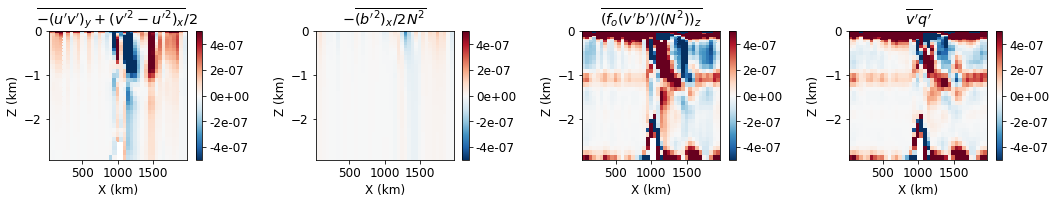

In [117]:
# u fluxes 
fig, ax = plt.subplots(1,4, figsize=(15,3))

im = ax[0].pcolormesh(Xcoarse/1e3, Z/1e3, (PV_fluxes_coarse['vpqp1_coarse'] + PV_fluxes_coarse['vpqp2_coarse']).sel(YCcoarse=1000e3, method='nearest') ,
                        vmin=-5e-7, vmax=5e-7, cmap='RdBu_r', rasterized=True)
ax[0].set_title('$\overline{-(u\'v\')_y + (v\'^2 - u\'^2)_x }$/2 ')
fig.colorbar(im, ax=ax[0], format='%.0e')
ax[0].set_xlabel('X (km)')
ax[0].set_ylabel('Z (km)')

im = ax[1].pcolormesh(Xcoarse/1e3, Z/1e3, (PV_fluxes_coarse['vpqp3_coarse']).sel(YCcoarse=1000e3, method='nearest') ,
                        vmin=-5e-7, vmax=5e-7, cmap='RdBu_r', rasterized=True)
ax[1].set_title('$-\overline{(b\'^2)_x/2N^2}$')
fig.colorbar(im, ax=ax[1], format='%.0e')
ax[1].set_xlabel('X (km)')
ax[1].set_ylabel('Z (km)')

im = ax[2].pcolormesh(Xcoarse/1e3, Z/1e3, PV_fluxes_coarse['vpqp4_coarse'].sel(YCcoarse=1000e3, method='nearest') ,
                        vmin=-5e-7, vmax=5e-7, cmap='RdBu_r', rasterized=True)
ax[2].set_title('$\overline{(f_o (v\'b\')/(N^2))_z}$')
fig.colorbar(im, ax=ax[2], format='%.0e')
ax[2].set_xlabel('X (km)')
ax[2].set_ylabel('Z (km)')

im = ax[3].pcolormesh(Xcoarse/1e3, Z/1e3, (PV_fluxes_coarse['vpqp1_coarse'] + PV_fluxes_coarse['vpqp2_coarse'] + 
                                     PV_fluxes_coarse['vpqp3_coarse'] + PV_fluxes_coarse['vpqp4_coarse']).sel(YCcoarse=1000e3, method='nearest') ,
                        vmin=-5e-7, vmax=5e-7, cmap='RdBu_r', rasterized=True)
ax[3].set_title('$\overline{v\'q\'}$')
ax[3].set_xlabel('X (km)')
ax[3].set_ylabel('Z (km)')
fig.colorbar(im, ax=ax[3], format='%.0e')

plt.tight_layout()
#plt.savefig('fig9b.pdf', dpi=200,bbox_inches='tight')

## Reconstructing PV fluxes

In [118]:
grid = Grid(Model_Tav, periodic='X')

In [119]:
PV_flux = xr.Dataset()

In [120]:
f = f0 + Trac_coarse.YCcoarse*beta

In [121]:
# v'q' using eddy flux of temp
#vq = grid.diff(f0 * grid.interp(T_coarse.VpTp.where(T_coarse['T_Z']>1.3e-4),'Z', boundary='extend')/
#                  (grid.diff(T_coarse['T'].where(T_coarse['T_Z']>1.3e-4),'Z', boundary='extend')/
#               grid.diff(T_coarse.Z, 'Z', boundary='extend')), 
#               'Z', boundary='extend')/ grid.diff(Model_Tav.Zl, 'Z', boundary='extend')

PV_flux['uq_raw_Tflux'] = grid.diff( grid.interp(T_coarse.UpTp,'Z', boundary='extend')/
                  (grid.diff(T_coarse['T'],'Z', boundary='extend')/
               grid.diff(T_coarse.Z, 'Z', boundary='extend'))* f, 
               'Z', boundary='extend')/ grid.diff(Model_Tav.Zl, 'Z', boundary='extend')

PV_flux['vq_raw_Tflux'] = grid.diff( grid.interp(T_coarse.VpTp,'Z', boundary='extend')/
                  (grid.diff(T_coarse['T'],'Z', boundary='extend')/
               grid.diff(T_coarse.Z, 'Z', boundary='extend')) * f, 
               'Z', boundary='extend')/ grid.diff(Model_Tav.Zl, 'Z', boundary='extend')
        
# v'q' using 
#vq2 = grid.diff(f0 * grid.interp(flux_rec_buoy.VpCp.where(T_coarse['T_Z']>1.3e-4),'Z', boundary='extend')/
#                  (grid.diff(T_coarse['T'].where(T_coarse['T_Z']>1.3e-4),'Z', boundary='extend')/
#               grid.diff(T_coarse.Z, 'Z', boundary='extend')), 
#               'Z', boundary='extend')/ grid.diff(Model_Tav.Zl, 'Z', boundary='extend')
        
PV_flux['uq_rec_Tflux'] = grid.diff( grid.interp(flux_rec_buoy.UpCp,'Z', boundary='extend')/
                  (grid.diff(T_coarse['T'],'Z', boundary='extend')/
               grid.diff(T_coarse.Z, 'Z', boundary='extend')) * f, 
               'Z', boundary='extend')/ grid.diff(Model_Tav.Zl, 'Z', boundary='extend')        

PV_flux['vq_rec_Tflux'] = grid.diff( grid.interp(flux_rec_buoy.VpCp,'Z', boundary='extend')/
                  (grid.diff(T_coarse['T'],'Z', boundary='extend')/
               grid.diff(T_coarse.Z, 'Z', boundary='extend')) * f, 
               'Z', boundary='extend')/ grid.diff(Model_Tav.Zl, 'Z', boundary='extend')        

In [123]:
PV_flux['uq_rec_ATflux'] = grid.diff(grid.interp(flux_rec_buoy_AT.UpCp * f,'Z', boundary='extend')/
                  (grid.diff(T_coarse['T'],'Z', boundary='extend')/
               grid.diff(T_coarse.Z, 'Z', boundary='extend')) , 
               'Z', boundary='extend')/ grid.diff(Model_Tav.Zl, 'Z', boundary='extend')        

PV_flux['vq_rec_ATflux'] = grid.diff( grid.interp(flux_rec_buoy_AT.VpCp* f,'Z', boundary='extend')/
                  (grid.diff(T_coarse['T'],'Z', boundary='extend')/
               grid.diff(T_coarse.Z, 'Z', boundary='extend')) , 
               'Z', boundary='extend')/ grid.diff(Model_Tav.Zl, 'Z', boundary='extend')  

In [124]:
Qx =  grid.diff(f0 * grid.interp(T_coarse.T_X,'Z', boundary='extend')/ 
                        (grid.diff(T_coarse['T'],'Z', boundary='extend')/
                          grid.diff(T_coarse.Z, 'Z', boundary='extend')),
                           'Z', boundary='extend')/ grid.diff(Model_Tav.Zl, 'Z', boundary='extend')

Qy = beta + grid.diff(f0 * grid.interp(T_coarse.T_Y,'Z', boundary='extend')/ 
                  (grid.diff(T_coarse['T'],'Z', boundary='extend')/
               grid.diff(T_coarse.Z, 'Z', boundary='extend')),
               'Z', boundary='extend')/ grid.diff(Model_Tav.Zl, 'Z', boundary='extend')

# v'q' using Q fluxes
PV_flux['uq_Ktensor'] = -( diff_tensor.Kcorr.sel(i=0, j=0)*Qx + \
             diff_tensor.Kcorr.sel(i=0, j=1)*Qy )

PV_flux['vq_Ktensor'] = -( diff_tensor.Kcorr.sel(i=1, j=0)*Qx + \
             diff_tensor.Kcorr.sel(i=1, j=1)*Qy )


/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/xgcm/grid.py:1005: RuntimeWarning: invalid value encountered in subtract
  return data_right - data_left


In [130]:
# v'q' using Q fluxes
PV_flux['uq_Stensor'] = -(diff_tensor.STcorr.sel(i=0, j=0)*Qx + \
             diff_tensor.STcorr.sel(i=0, j=1)*Qy )

PV_flux['vq_Stensor'] = -(diff_tensor.STcorr.sel(i=1, j=0)*Qx + \
             diff_tensor.STcorr.sel(i=1, j=1)*Qy )

YZ Plots (We focus on only the buoyancy flux component, assuming that it dominates - even though it does not always in the top 1000m). 

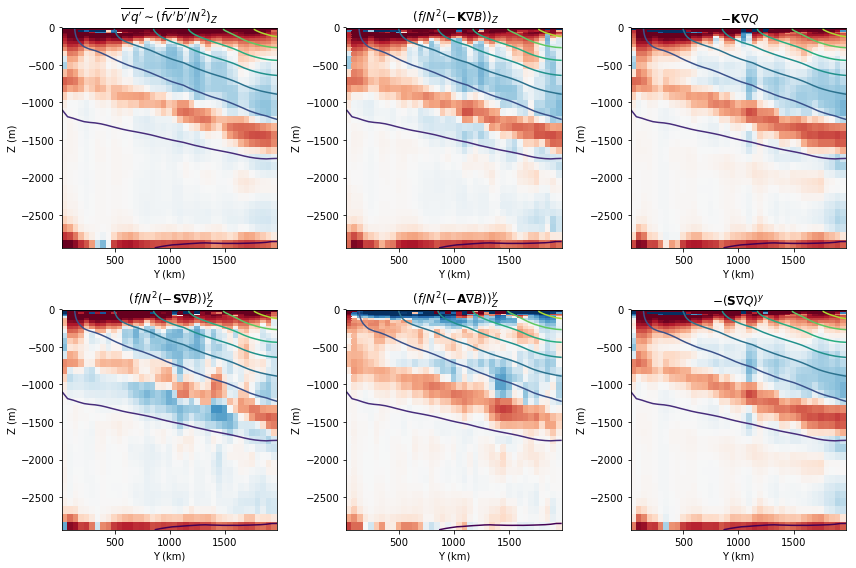

In [79]:
# y flux
fig, ax = plt.subplots(2,3,figsize=(12,8))
 
ax[0,0].pcolormesh(Ycoarse/1e3, Z, PV_flux['vq_raw_Tflux'].sel(XCcoarse=100e3, method='nearest'),
                 vmin=-3e-6, vmax=3e-6, cmap='RdBu_r',
                rasterized=True, norm=colors.SymLogNorm(linthresh=1e-7))

ax[0,0].contour(Ycoarse/1e3, Z, T_coarse['T'].sel(XCcoarse=100e3, method='nearest'),
              levels=np.linspace(0,8,9))
ax[0,0].set_title('$\overline{v\'q\'} \sim (f \overline{v\'b\'} /N^2)_Z$ ')
ax[0,0].set_ylabel('Z (m)')
ax[0,0].set_xlabel('Y (km)')

ax[0,1].pcolormesh(Ycoarse/1e3, Z, PV_flux['vq_rec_Tflux'].sel(XCcoarse=100e3, method='nearest'),
                 vmin=-3e-6, vmax=3e-6, cmap='RdBu_r',
                rasterized=True, norm=colors.SymLogNorm(linthresh=1e-7))
ax[0,1].contour(Ycoarse/1e3, Z, T_coarse['T'].sel(XCcoarse=100e3, method='nearest'),
              levels=np.linspace(0,8,9))
ax[0,1].set_title(r' $(f/N^2 (-\mathbf{K} \nabla B))_Z$')
ax[0,1].set_ylabel('Z (m)')
ax[0,1].set_xlabel('Y (km)')

ax[0,2].pcolormesh(Ycoarse/1e3, Z, PV_flux['vq_Ktensor'].sel(XCcoarse=100e3, method='nearest'), 
                      vmin=-3e-6, vmax=3e-6, cmap='RdBu_r',
                     rasterized=True, norm=colors.SymLogNorm(linthresh=1e-7))
ax[0,2].contour(Ycoarse/1e3, Z, T_coarse['T'].sel(XCcoarse=100e3, method='nearest'),
              levels=np.linspace(0,8,9))
ax[0,2].set_title(r' $-\mathbf{K} \nabla Q$')
ax[0,2].set_ylabel('Z (m)')
ax[0,2].set_xlabel('Y (km)')

ax[1,0].pcolormesh(Ycoarse/1e3, Z, (PV_flux['vq_rec_Tflux']  -PV_flux['vq_rec_ATflux'] ).sel(XCcoarse=100e3, method='nearest'), 
                      vmin=-3e-6, vmax=3e-6, cmap='RdBu_r',
                     rasterized=True, norm=colors.SymLogNorm(linthresh=1e-7))
ax[1,0].contour(Ycoarse/1e3, Z, T_coarse['T'].sel(XCcoarse=100e3, method='nearest'),
              levels=np.linspace(0,8,9))
ax[1,0].set_title(r' $(f/N^2 (-\mathbf{S} \nabla B))_Z^y$')
ax[1,0].set_ylabel('Z (m)')
ax[1,0].set_xlabel('Y (km)')

ax[1,1].pcolormesh(Ycoarse/1e3, Z, PV_flux['vq_rec_ATflux'].sel(XCcoarse=100e3, method='nearest'), 
                      vmin=-3e-6, vmax=3e-6, cmap='RdBu_r',
                     rasterized=True, norm=colors.SymLogNorm(linthresh=1e-7))
ax[1,1].contour(Ycoarse/1e3, Z, T_coarse['T'].sel(XCcoarse=100e3, method='nearest'),
              levels=np.linspace(0,8,9))
ax[1,1].set_title(r' $(f/N^2 (-\mathbf{A} \nabla B))_Z^y$')
ax[1,1].set_ylabel('Z (m)')
ax[1,1].set_xlabel('Y (km)')


ax[1,2].pcolormesh(Ycoarse/1e3, Z, PV_flux['vq_Stensor'].sel(XCcoarse=100e3, method='nearest'),
                 vmin=-3e-6, vmax=3e-6, cmap='RdBu_r',
                rasterized=True, norm=colors.SymLogNorm(linthresh=1e-7))
ax[1,2].contour(Ycoarse/1e3, Z, T_coarse['T'].sel(XCcoarse=100e3, method='nearest'),
              levels=np.linspace(0,8,9))
ax[1,2].set_title(r'$-(\mathbf{S} \nabla Q)^y $')
ax[1,2].set_ylabel('Z (m)')
ax[1,2].set_xlabel('Y (km)')


plt.tight_layout()

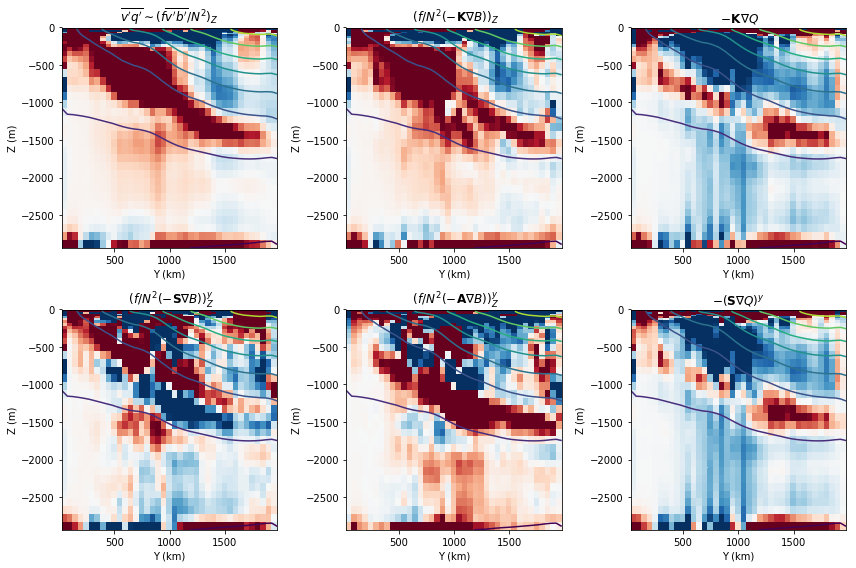

In [64]:
# y flux (non-log plot)
fig, ax = plt.subplots(2,3,figsize=(12,8))
 
ax[0,0].pcolormesh(Ycoarse/1e3, Z, PV_flux['vq_raw_Tflux'].sel(XCcoarse=1200e3, method='nearest'),
                 vmin=-5e-7, vmax=5e-7, cmap='RdBu_r',
                rasterized=True)

ax[0,0].contour(Ycoarse/1e3, Z, T_coarse['T'].sel(XCcoarse=1200e3, method='nearest'),
              levels=np.linspace(0,8,9))
ax[0,0].set_title('$\overline{v\'q\'} \sim (f \overline{v\'b\'} /N^2)_Z$ ')
ax[0,0].set_ylabel('Z (m)')
ax[0,0].set_xlabel('Y (km)')

ax[0,1].pcolormesh(Ycoarse/1e3, Z, PV_flux['vq_rec_Tflux'].sel(XCcoarse=1200e3, method='nearest'),
                 vmin=-5e-7, vmax=5e-7, cmap='RdBu_r',
                rasterized=True)
ax[0,1].contour(Ycoarse/1e3, Z, T_coarse['T'].sel(XCcoarse=1200e3, method='nearest'),
              levels=np.linspace(0,8,9))
ax[0,1].set_title(r' $(f/N^2 (-\mathbf{K} \nabla B))_Z$')
ax[0,1].set_ylabel('Z (m)')
ax[0,1].set_xlabel('Y (km)')

ax[0,2].pcolormesh(Ycoarse/1e3, Z, PV_flux['vq_Ktensor'].sel(XCcoarse=1200e3, method='nearest'), 
                      vmin=-5e-7, vmax=5e-7, cmap='RdBu_r',
                     rasterized=True)
ax[0,2].contour(Ycoarse/1e3, Z, T_coarse['T'].sel(XCcoarse=1200e3, method='nearest'),
              levels=np.linspace(0,8,9))
ax[0,2].set_title(r' $-\mathbf{K} \nabla Q$')
ax[0,2].set_ylabel('Z (m)')
ax[0,2].set_xlabel('Y (km)')

ax[1,0].pcolormesh(Ycoarse/1e3, Z, (PV_flux['vq_rec_Tflux']  -PV_flux['vq_rec_ATflux'] ).sel(XCcoarse=1200e3, method='nearest'), 
                      vmin=-5e-7, vmax=5e-7, cmap='RdBu_r',
                     rasterized=True)
ax[1,0].contour(Ycoarse/1e3, Z, T_coarse['T'].sel(XCcoarse=1200e3, method='nearest'),
              levels=np.linspace(0,8,9))
ax[1,0].set_title(r' $(f/N^2 (-\mathbf{S} \nabla B))_Z^y$')
ax[1,0].set_ylabel('Z (m)')
ax[1,0].set_xlabel('Y (km)')

ax[1,1].pcolormesh(Ycoarse/1e3, Z, PV_flux['vq_rec_ATflux'].sel(XCcoarse=1200e3, method='nearest'), 
                      vmin=-5e-7, vmax=5e-7, cmap='RdBu_r',
                     rasterized=True)
ax[1,1].contour(Ycoarse/1e3, Z, T_coarse['T'].sel(XCcoarse=1200e3, method='nearest'),
              levels=np.linspace(0,8,9))
ax[1,1].set_title(r' $(f/N^2 (-\mathbf{A} \nabla B))_Z^y$')
ax[1,1].set_ylabel('Z (m)')
ax[1,1].set_xlabel('Y (km)')


ax[1,2].pcolormesh(Ycoarse/1e3, Z, PV_flux['vq_Stensor'].sel(XCcoarse=1200e3, method='nearest'),
                 vmin=-5e-7, vmax=5e-7, cmap='RdBu_r',
                rasterized=True)
ax[1,2].contour(Ycoarse/1e3, Z, T_coarse['T'].sel(XCcoarse=1200e3, method='nearest'),
              levels=np.linspace(0,8,9))
ax[1,2].set_title(r'$-(\mathbf{S} \nabla Q)^y $')
ax[1,2].set_ylabel('Z (m)')
ax[1,2].set_xlabel('Y (km)')


plt.tight_layout()

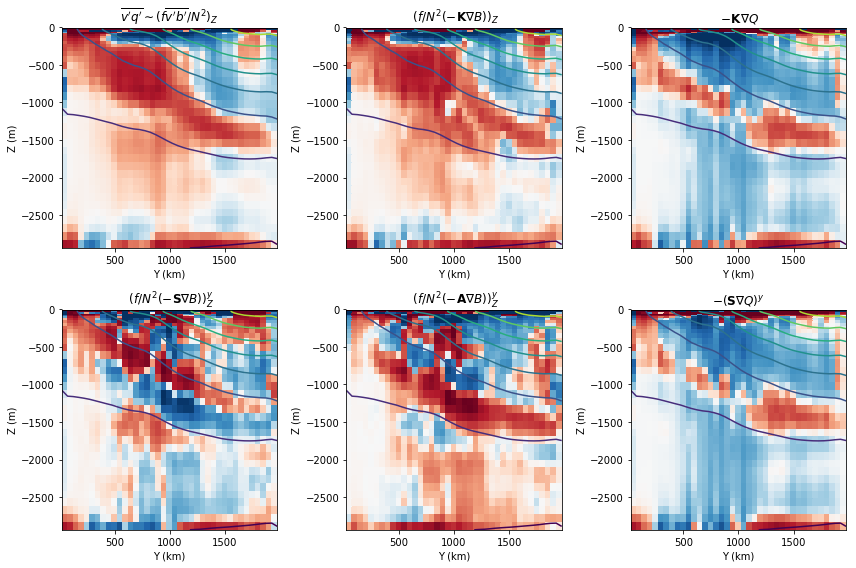

In [95]:
# y flux
fig, ax = plt.subplots(2,3,figsize=(12,8))
 
ax[0,0].pcolormesh(Ycoarse/1e3, Z, PV_flux['vq_raw_Tflux'].sel(XCcoarse=1200e3, method='nearest'),
                 vmin=-3e-6, vmax=3e-6, cmap='RdBu_r',
                rasterized=True, norm=colors.SymLogNorm(linthresh=1e-7))

ax[0,0].contour(Ycoarse/1e3, Z, T_coarse['T'].sel(XCcoarse=1200e3, method='nearest'),
              levels=np.linspace(0,8,9))
ax[0,0].set_title('$\overline{v\'q\'} \sim (f \overline{v\'b\'} /N^2)_Z$ ')
ax[0,0].set_ylabel('Z (m)')
ax[0,0].set_xlabel('Y (km)')

ax[0,1].pcolormesh(Ycoarse/1e3, Z, PV_flux['vq_rec_Tflux'].sel(XCcoarse=1200e3, method='nearest'),
                 vmin=-3e-6, vmax=3e-6, cmap='RdBu_r',
                rasterized=True, norm=colors.SymLogNorm(linthresh=1e-7))
ax[0,1].contour(Ycoarse/1e3, Z, T_coarse['T'].sel(XCcoarse=1200e3, method='nearest'),
              levels=np.linspace(0,8,9))
ax[0,1].set_title(r' $(f/N^2 (-\mathbf{K} \nabla B))_Z$')
ax[0,1].set_ylabel('Z (m)')
ax[0,1].set_xlabel('Y (km)')

ax[0,2].pcolormesh(Ycoarse/1e3, Z, PV_flux['vq_Ktensor'].sel(XCcoarse=1200e3, method='nearest'), 
                      vmin=-3e-6, vmax=3e-6, cmap='RdBu_r',
                     rasterized=True, norm=colors.SymLogNorm(linthresh=1e-7))
ax[0,2].contour(Ycoarse/1e3, Z, T_coarse['T'].sel(XCcoarse=1200e3, method='nearest'),
              levels=np.linspace(0,8,9))
ax[0,2].set_title(r' $-\mathbf{K} \nabla Q$')
ax[0,2].set_ylabel('Z (m)')
ax[0,2].set_xlabel('Y (km)')

ax[1,0].pcolormesh(Ycoarse/1e3, Z, (PV_flux['vq_rec_Tflux']  -PV_flux['vq_rec_ATflux'] ).sel(XCcoarse=1200e3, method='nearest'), 
                      vmin=-3e-6, vmax=3e-6, cmap='RdBu_r',
                     rasterized=True, norm=colors.SymLogNorm(linthresh=1e-7))
ax[1,0].contour(Ycoarse/1e3, Z, T_coarse['T'].sel(XCcoarse=1200e3, method='nearest'),
              levels=np.linspace(0,8,9))
ax[1,0].set_title(r' $(f/N^2 (-\mathbf{S} \nabla B))_Z^y$')
ax[1,0].set_ylabel('Z (m)')
ax[1,0].set_xlabel('Y (km)')

ax[1,1].pcolormesh(Ycoarse/1e3, Z, PV_flux['vq_rec_ATflux'].sel(XCcoarse=1200e3, method='nearest'), 
                      vmin=-3e-6, vmax=3e-6, cmap='RdBu_r',
                     rasterized=True, norm=colors.SymLogNorm(linthresh=1e-7))
ax[1,1].contour(Ycoarse/1e3, Z, T_coarse['T'].sel(XCcoarse=1200e3, method='nearest'),
              levels=np.linspace(0,8,9))
ax[1,1].set_title(r' $(f/N^2 (-\mathbf{A} \nabla B))_Z^y$')
ax[1,1].set_ylabel('Z (m)')
ax[1,1].set_xlabel('Y (km)')


ax[1,2].pcolormesh(Ycoarse/1e3, Z, PV_flux['vq_Stensor'].sel(XCcoarse=1200e3, method='nearest'),
                 vmin=-3e-6, vmax=3e-6, cmap='RdBu_r',
                rasterized=True, norm=colors.SymLogNorm(linthresh=1e-7))
ax[1,2].contour(Ycoarse/1e3, Z, T_coarse['T'].sel(XCcoarse=1200e3, method='nearest'),
              levels=np.linspace(0,8,9))
ax[1,2].set_title(r'$-(\mathbf{S} \nabla Q)^y $')
ax[1,2].set_ylabel('Z (m)')
ax[1,2].set_xlabel('Y (km)')


plt.tight_layout()

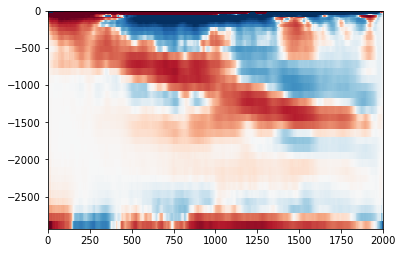

In [94]:
plt.pcolormesh(vpqp.YC/1e3, Z, vpqp.sel(XC=1200e3, method='nearest'),
                 vmin=-3e-6, vmax=3e-6, cmap='RdBu_r',
                rasterized=True, norm=colors.SymLogNorm(linthresh=1e-7))
#vpqp.sel(XC=1200e3, method='nearest').plot(vmin=-3e-6)

# Correlations b/w PV fluxes

### Upstream

In [53]:
def pearson_corr(ds1, ds2):
    corr = ((ds1 - ds1.mean())*(ds2 - ds2.mean())).mean() / ( ((ds1 - ds1.mean())**2).mean()**0.5 * ((ds2 - ds2.mean())**2).mean()**0.5 )
    return corr 

In [143]:
PV_flux_Vcoarse = (PV_fluxes_coarse['vpqp1_coarse'] + PV_fluxes_coarse['vpqp2_coarse'] + 
PV_fluxes_coarse['vpqp3_coarse'] + PV_fluxes_coarse['vpqp4_coarse'])

In [147]:
corr1 = pearson_corr(PV_flux_Vcoarse.sel(XCcoarse=slice(0,800e3), Z=slice(-300,-1800)) , 
                    PV_flux.vq_rec_Tflux.sel(XCcoarse=slice(0,800e3), Z=slice(-300,-1800)))
corr2 = pearson_corr(PV_flux_Vcoarse.sel(XCcoarse=slice(0,800e3), Z=slice(-300,-1800)) , 
                    PV_flux.vq_rec_ATflux.sel(XCcoarse=slice(0,800e3), Z=slice(-300,-1800)))
corr3 = pearson_corr(PV_flux_Vcoarse.sel(XCcoarse=slice(0,800e3), Z=slice(-300,-1800)) , 
                    (PV_flux.vq_rec_Tflux - PV_flux.vq_rec_ATflux).sel(XCcoarse=slice(0,800e3), Z=slice(-300,-1800)))
corr4 = pearson_corr(PV_flux_Vcoarse.sel(XCcoarse=slice(0,800e3), Z=slice(-300,-1800)) , 
                     PV_flux.vq_Ktensor.sel(XCcoarse=slice(0,800e3), Z=slice(-300,-1800)))
corr5 = pearson_corr(PV_flux_Vcoarse.sel(XCcoarse=slice(0,800e3), Z=slice(-300,-1800)) , 
                     PV_flux.vq_Stensor.sel(XCcoarse=slice(0,800e3), Z=slice(-300,-1800)))
corr6 = pearson_corr(PV_flux_Vcoarse.sel(XCcoarse=slice(0,800e3), Z=slice(-300,-1800)) , 
                     (PV_flux.vq_Ktensor - PV_flux.vq_Stensor).sel(XCcoarse=slice(0,800e3), Z=slice(-300,-1800)))

corr1, corr2, corr3, corr4, corr5, corr6

(<xarray.DataArray ()>
 array(0.850498, dtype=float32), <xarray.DataArray ()>
 array(0.700084, dtype=float32), <xarray.DataArray ()>
 array(0.441522, dtype=float32), <xarray.DataArray ()>
 array(0.905321, dtype=float32), <xarray.DataArray ()>
 array(0.895036, dtype=float32), <xarray.DataArray ()>
 array(0.260055, dtype=float32))

Text(0.5, 1.0, ' X = (0,800km); Z = (-300, -1800m)')

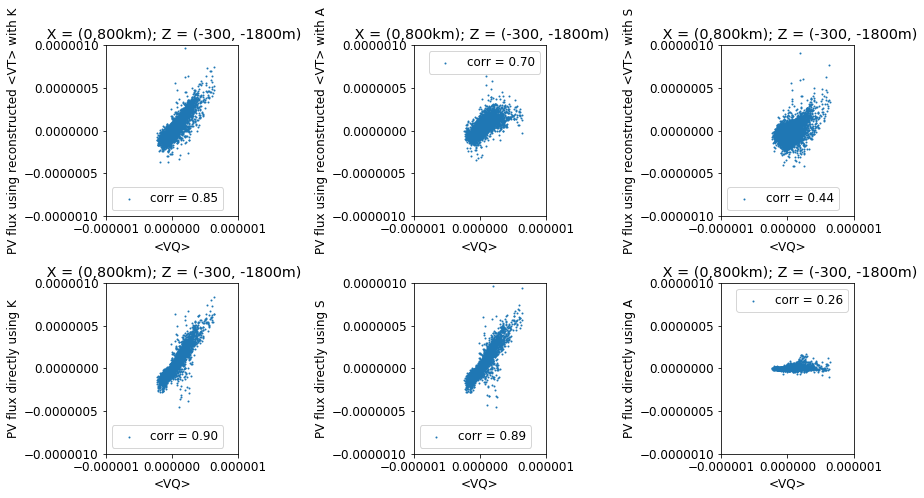

In [177]:
plt.figure(figsize=(13,7))

plt.subplot(231)
plt.scatter(PV_flux_Vcoarse.sel(XCcoarse=slice(0,800e3), Z=slice(-300,-1800)) ,
            PV_flux.vq_rec_Tflux.sel(XCcoarse=slice(0,800e3), Z=slice(-300,-1800)), s=1, label='corr = 0.85')
plt.xlim([-1e-6, 1e-6])
plt.ylim([-1e-6, 1e-6])
#plt.xscale('symlog',linthreshx=1e-9)
#plt.yscale('symlog',linthreshy=1e-9)
plt.xlabel('<VQ>')
plt.ylabel('PV flux using reconstructed <VT> with K')
plt.legend()
plt.tight_layout()
plt.title(' X = (0,800km); Z = (-300, -1800m)' )

plt.subplot(232)
plt.scatter(PV_flux_Vcoarse.sel(XCcoarse=slice(0,800e3), Z=slice(-300,-1800)) ,
            PV_flux.vq_rec_ATflux.sel(XCcoarse=slice(0,800e3), Z=slice(-300,-1800)), s=1, label='corr = 0.70')
plt.xlim([-1e-6, 1e-6])
plt.ylim([-1e-6, 1e-6])
#plt.xscale('symlog',linthreshx=1e-9)
#plt.yscale('symlog',linthreshy=1e-9)
plt.xlabel('<VQ>')
plt.ylabel('PV flux using reconstructed <VT> with A')
plt.legend()
plt.tight_layout()
plt.title(' X = (0,800km); Z = (-300, -1800m)' )

plt.subplot(233)
plt.scatter(PV_flux_Vcoarse.sel(XCcoarse=slice(0,800e3), Z=slice(-300,-1800)) ,
            (PV_flux.vq_rec_Tflux - PV_flux.vq_rec_ATflux).sel(XCcoarse=slice(0,800e3), Z=slice(-300,-1800)), s=1,
            label='corr = 0.44')
plt.xlim([-1e-6, 1e-6])
plt.ylim([-1e-6, 1e-6])

plt.xlabel('<VQ>')
plt.ylabel('PV flux using reconstructed <VT> with S')
plt.legend()
plt.tight_layout()
plt.title(' X = (0,800km); Z = (-300, -1800m)' )

plt.subplot(234)
plt.scatter(PV_flux_Vcoarse.sel(XCcoarse=slice(0,800e3), Z=slice(-300,-1800)) ,
            PV_flux.vq_Ktensor .sel(XCcoarse=slice(0,800e3), Z=slice(-300,-1800)), s=1,
            label='corr = 0.90')
plt.xlim([-1e-6, 1e-6])
plt.ylim([-1e-6, 1e-6])

plt.xlabel('<VQ>')
plt.ylabel('PV flux directly using K')
plt.legend()
plt.tight_layout()
plt.title(' X = (0,800km); Z = (-300, -1800m)' )

plt.subplot(235)
plt.scatter(PV_flux_Vcoarse.sel(XCcoarse=slice(0,800e3), Z=slice(-300,-1800)) ,
            PV_flux.vq_Stensor .sel(XCcoarse=slice(0,800e3), Z=slice(-300,-1800)), s=1,
            label='corr = 0.89')
plt.xlim([-1e-6, 1e-6])
plt.ylim([-1e-6, 1e-6])

plt.xlabel('<VQ>')
plt.ylabel('PV flux directly using S')
plt.legend()

plt.subplot(236)
plt.scatter(PV_flux_Vcoarse.sel(XCcoarse=slice(0,800e3), Z=slice(-300,-1800)) ,
            (PV_flux.vq_Ktensor - PV_flux.vq_Stensor).sel(XCcoarse=slice(0,800e3), Z=slice(-300,-1800)), s=1,
            label='corr = 0.26')
plt.xlim([-1e-6, 1e-6])
plt.ylim([-1e-6, 1e-6])

plt.xlabel('<VQ>')
plt.ylabel('PV flux directly using A')
plt.legend()
plt.tight_layout()
plt.title(' X = (0,800km); Z = (-300, -1800m)' )

Text(0.5, 1.0, ' X = (0,800km); Z = (-300, -1800m)')

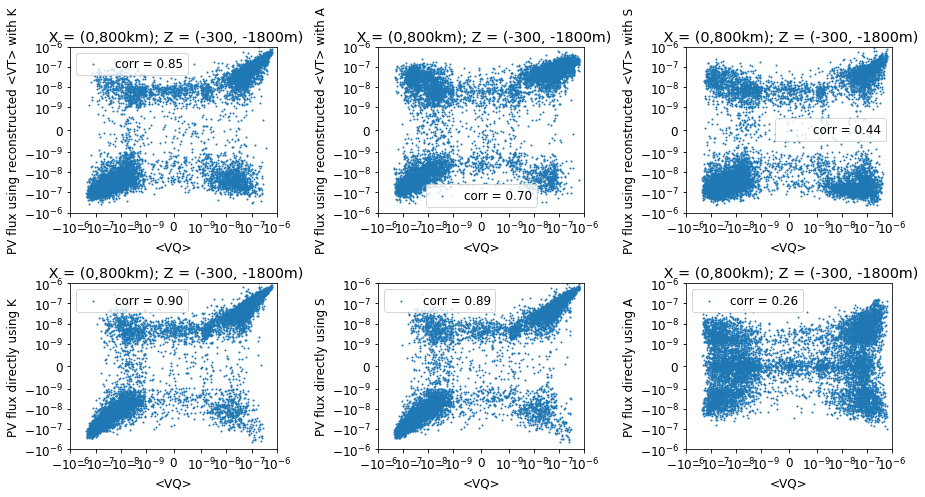

In [149]:
plt.figure(figsize=(13,7))

plt.subplot(231)
plt.scatter(PV_flux_Vcoarse.sel(XCcoarse=slice(0,800e3), Z=slice(-300,-1800)) ,
            PV_flux.vq_rec_Tflux.sel(XCcoarse=slice(0,800e3), Z=slice(-300,-1800)), s=1, label='corr = 0.85')
plt.xlim([-1e-6, 1e-6])
plt.ylim([-1e-6, 1e-6])
plt.xscale('symlog',linthreshx=1e-9)
plt.yscale('symlog',linthreshy=1e-9)
plt.xlabel('<VQ>')
plt.ylabel('PV flux using reconstructed <VT> with K')
plt.legend()
plt.tight_layout()
plt.title(' X = (0,800km); Z = (-300, -1800m)' )

plt.subplot(232)
plt.scatter(PV_flux_Vcoarse.sel(XCcoarse=slice(0,800e3), Z=slice(-300,-1800)) ,
            PV_flux.vq_rec_ATflux.sel(XCcoarse=slice(0,800e3), Z=slice(-300,-1800)), s=1, label='corr = 0.70')
plt.xlim([-1e-6, 1e-6])
plt.ylim([-1e-6, 1e-6])
plt.xscale('symlog',linthreshx=1e-9)
plt.yscale('symlog',linthreshy=1e-9)
plt.xlabel('<VQ>')
plt.ylabel('PV flux using reconstructed <VT> with A')
plt.legend()
plt.tight_layout()
plt.title(' X = (0,800km); Z = (-300, -1800m)' )

plt.subplot(233)
plt.scatter(PV_flux_Vcoarse.sel(XCcoarse=slice(0,800e3), Z=slice(-300,-1800)) ,
            (PV_flux.vq_rec_Tflux - PV_flux.vq_rec_ATflux).sel(XCcoarse=slice(0,800e3), Z=slice(-300,-1800)), s=1,
            label='corr = 0.44')
plt.xlim([-1e-6, 1e-6])
plt.ylim([-1e-6, 1e-6])
plt.xscale('symlog',linthreshx=1e-9)
plt.yscale('symlog',linthreshy=1e-9)
plt.xlabel('<VQ>')
plt.ylabel('PV flux using reconstructed <VT> with S')
plt.legend()
plt.tight_layout()
plt.title(' X = (0,800km); Z = (-300, -1800m)' )

plt.subplot(234)
plt.scatter(PV_flux_Vcoarse.sel(XCcoarse=slice(0,800e3), Z=slice(-300,-1800)) ,
            PV_flux.vq_Ktensor .sel(XCcoarse=slice(0,800e3), Z=slice(-300,-1800)), s=1,
            label='corr = 0.90')
plt.xlim([-1e-6, 1e-6])
plt.ylim([-1e-6, 1e-6])
plt.xscale('symlog',linthreshx=1e-9)
plt.yscale('symlog',linthreshy=1e-9)
plt.xlabel('<VQ>')
plt.ylabel('PV flux directly using K')
plt.legend()
plt.tight_layout()
plt.title(' X = (0,800km); Z = (-300, -1800m)' )

plt.subplot(235)
plt.scatter(PV_flux_Vcoarse.sel(XCcoarse=slice(0,800e3), Z=slice(-300,-1800)) ,
            PV_flux.vq_Stensor .sel(XCcoarse=slice(0,800e3), Z=slice(-300,-1800)), s=1,
            label='corr = 0.89')
plt.xlim([-1e-6, 1e-6])
plt.ylim([-1e-6, 1e-6])
plt.xscale('symlog',linthreshx=1e-9)
plt.yscale('symlog',linthreshy=1e-9)
plt.xlabel('<VQ>')
plt.ylabel('PV flux directly using S')
plt.legend()

plt.subplot(236)
plt.scatter(PV_flux_Vcoarse.sel(XCcoarse=slice(0,800e3), Z=slice(-300,-1800)) ,
            (PV_flux.vq_Ktensor - PV_flux.vq_Stensor).sel(XCcoarse=slice(0,800e3), Z=slice(-300,-1800)), s=1,
            label='corr = 0.26')
plt.xlim([-1e-6, 1e-6])
plt.ylim([-1e-6, 1e-6])
plt.xscale('symlog',linthreshx=1e-9)
plt.yscale('symlog',linthreshy=1e-9)
plt.xlabel('<VQ>')
plt.ylabel('PV flux directly using A')
plt.legend()
plt.tight_layout()
plt.title(' X = (0,800km); Z = (-300, -1800m)' )

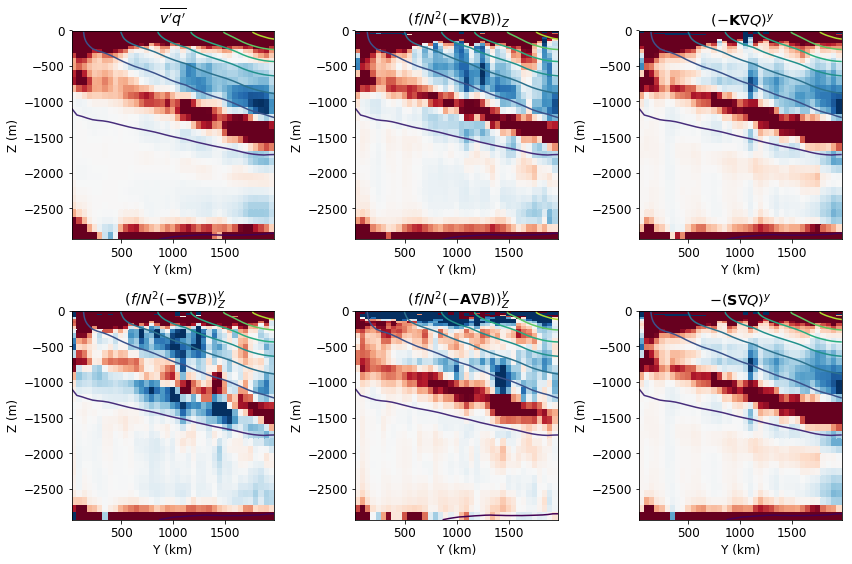

In [163]:
# y flux
fig, ax = plt.subplots(2,3,figsize=(12,8))
 
ax[0,0].pcolormesh(Ycoarse/1e3, Z, PV_flux_Vcoarse.sel(XCcoarse=100e3, method='nearest'),
                 vmin=-0.2e-6, vmax=0.2e-6, cmap='RdBu_r',
                rasterized=True)

ax[0,0].contour(Ycoarse/1e3, Z, T_coarse['T'].sel(XCcoarse=100e3, method='nearest'),
              levels=np.linspace(0,8,9))
ax[0,0].set_title('$\overline{v\'q\'}$ ')
ax[0,0].set_ylabel('Z (m)')
ax[0,0].set_xlabel('Y (km)')

ax[0,1].pcolormesh(Ycoarse/1e3, Z, PV_flux['vq_rec_Tflux'].sel(XCcoarse=100e3, method='nearest'),
                 vmin=-0.2e-6, vmax=0.2e-6, cmap='RdBu_r',
                rasterized=True)
ax[0,1].contour(Ycoarse/1e3, Z, T_coarse['T'].sel(XCcoarse=100e3, method='nearest'),
              levels=np.linspace(0,8,9))
ax[0,1].set_title(r' $(f/N^2 (-\mathbf{K} \nabla B))_Z$')
ax[0,1].set_ylabel('Z (m)')
ax[0,1].set_xlabel('Y (km)')

ax[0,2].pcolormesh(Ycoarse/1e3, Z, PV_flux['vq_Ktensor'].sel(XCcoarse=100e3, method='nearest'), 
                      vmin=-0.2e-6, vmax=0.2e-6, cmap='RdBu_r',
                     rasterized=True)
ax[0,2].contour(Ycoarse/1e3, Z, T_coarse['T'].sel(XCcoarse=100e3, method='nearest'),
              levels=np.linspace(0,8,9))
ax[0,2].set_title(r' $(-\mathbf{K} \nabla Q)^y$')
ax[0,2].set_ylabel('Z (m)')
ax[0,2].set_xlabel('Y (km)')

ax[1,0].pcolormesh(Ycoarse/1e3, Z, (PV_flux['vq_rec_Tflux']  -PV_flux['vq_rec_ATflux'] ).sel(XCcoarse=100e3, method='nearest'), 
                      vmin=-0.2e-6, vmax=0.2e-6, cmap='RdBu_r',
                     rasterized=True)
ax[1,0].contour(Ycoarse/1e3, Z, T_coarse['T'].sel(XCcoarse=100e3, method='nearest'),
              levels=np.linspace(0,8,9))
ax[1,0].set_title(r' $(f/N^2 (-\mathbf{S} \nabla B))_Z^y$')
ax[1,0].set_ylabel('Z (m)')
ax[1,0].set_xlabel('Y (km)')

ax[1,1].pcolormesh(Ycoarse/1e3, Z, PV_flux['vq_rec_ATflux'].sel(XCcoarse=100e3, method='nearest'), 
                      vmin=-0.2e-6, vmax=0.2e-6, cmap='RdBu_r',
                     rasterized=True)
ax[1,1].contour(Ycoarse/1e3, Z, T_coarse['T'].sel(XCcoarse=100e3, method='nearest'),
              levels=np.linspace(0,8,9))
ax[1,1].set_title(r' $(f/N^2 (-\mathbf{A} \nabla B))_Z^y$')
ax[1,1].set_ylabel('Z (m)')
ax[1,1].set_xlabel('Y (km)')


ax[1,2].pcolormesh(Ycoarse/1e3, Z, PV_flux['vq_Stensor'].sel(XCcoarse=100e3, method='nearest'),
                 vmin=-0.2e-6, vmax=0.2e-6, cmap='RdBu_r',
                rasterized=True)
ax[1,2].contour(Ycoarse/1e3, Z, T_coarse['T'].sel(XCcoarse=100e3, method='nearest'),
              levels=np.linspace(0,8,9))
ax[1,2].set_title(r'$-(\mathbf{S} \nabla Q)^y $')
ax[1,2].set_ylabel('Z (m)')
ax[1,2].set_xlabel('Y (km)')


plt.tight_layout()

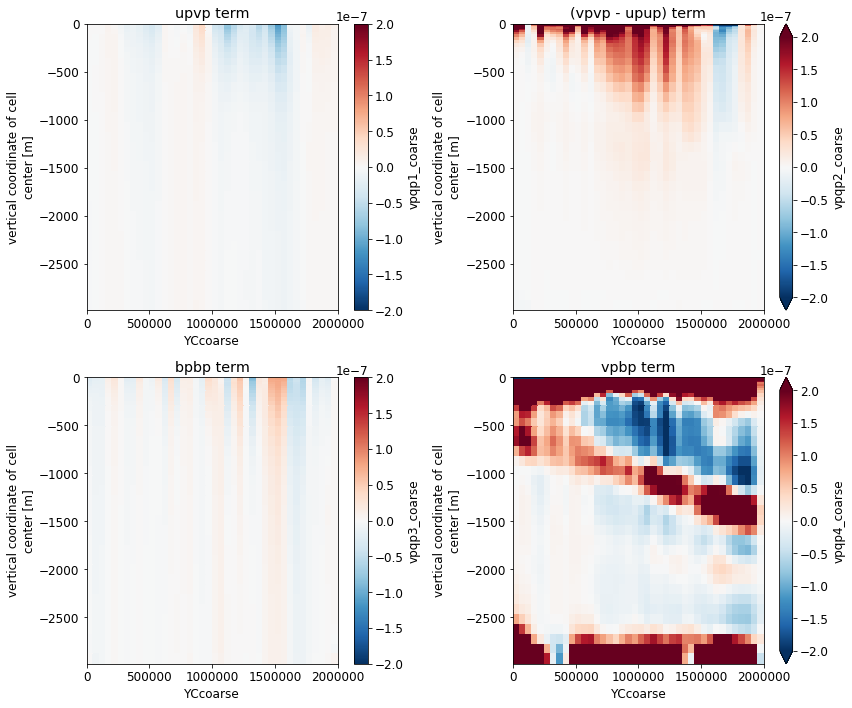

In [168]:
plt.figure(figsize=(12,10))

plt.subplot(221)
PV_fluxes_coarse['vpqp1_coarse'].sel(XCcoarse=100e3, method='nearest').plot( vmin=-0.2e-6, vmax=0.2e-6, cmap='RdBu_r')
plt.title('upvp term')

plt.subplot(222)
PV_fluxes_coarse['vpqp2_coarse'].sel(XCcoarse=100e3, method='nearest').plot( vmin=-0.2e-6, vmax=0.2e-6, cmap='RdBu_r')
plt.title('(vpvp - upup) term')

plt.subplot(223)
PV_fluxes_coarse['vpqp3_coarse'].sel(XCcoarse=100e3, method='nearest').plot( vmin=-0.2e-6, vmax=0.2e-6, cmap='RdBu_r')
plt.title('bpbp term')

plt.subplot(224)
PV_fluxes_coarse['vpqp4_coarse'].sel(XCcoarse=100e3, method='nearest').plot( vmin=-0.2e-6, vmax=0.2e-6, cmap='RdBu_r')
plt.title('vpbp term')

plt.tight_layout()

### Downstream

In [160]:
corr1 = pearson_corr(PV_flux_Vcoarse.sel(XCcoarse=slice(1200e3,2000e3), Z=slice(-300,-1800)) , 
                    PV_flux.vq_rec_Tflux.sel(XCcoarse=slice(1200e3,2000e3), Z=slice(-300,-1800)))
corr2 = pearson_corr(PV_flux_Vcoarse.sel(XCcoarse=slice(1200e3,2000e3), Z=slice(-300,-1800)) , 
                    PV_flux.vq_rec_ATflux.sel(XCcoarse=slice(1200e3,2000e3), Z=slice(-300,-1800)))
corr3 = pearson_corr(PV_flux_Vcoarse.sel(XCcoarse=slice(1200e3,2000e3), Z=slice(-300,-1800)) , 
                    (PV_flux.vq_rec_Tflux - PV_flux.vq_rec_ATflux).sel(XCcoarse=slice(1200e3,2000e3), Z=slice(-300,-1800)))
corr4 = pearson_corr(PV_flux_Vcoarse.sel(XCcoarse=slice(1200e3,2000e3), Z=slice(-300,-1800)) , 
                    PV_flux.vq_Ktensor.sel(XCcoarse=slice(1200e3,2000e3), Z=slice(-300,-1800)))
corr5 = pearson_corr(PV_flux_Vcoarse.sel(XCcoarse=slice(1200e3,2000e3), Z=slice(-300,-1800)) , 
                     PV_flux.vq_Stensor.sel(XCcoarse=slice(1200e3,2000e3), Z=slice(-300,-1800)))
corr6 = pearson_corr(PV_flux_Vcoarse.sel(XCcoarse=slice(1200e3,2000e3), Z=slice(-300,-1800)) , 
                     (PV_flux.vq_Ktensor - PV_flux.vq_Stensor).sel(XCcoarse=slice(1200e3,2000e3), Z=slice(-300,-1800)))


corr1, corr2, corr3, corr4, corr5, corr6

(<xarray.DataArray ()>
 array(0.584691, dtype=float32), <xarray.DataArray ()>
 array(0.141875, dtype=float32), <xarray.DataArray ()>
 array(0.124894, dtype=float32), <xarray.DataArray ()>
 array(0.637807, dtype=float32), <xarray.DataArray ()>
 array(0.551169, dtype=float32), <xarray.DataArray ()>
 array(0.342911, dtype=float32))

Text(0.5, 1.0, ' X = (0,800km); Z = (-300, -1800m)')

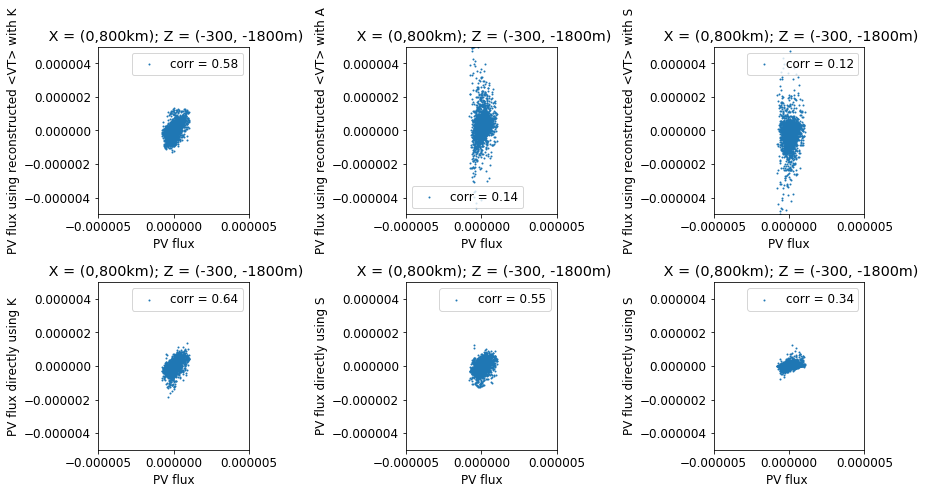

In [178]:
plt.figure(figsize=(13,7))

plt.subplot(231)
plt.scatter(PV_flux_Vcoarse.sel(XCcoarse=slice(1200e3,2000e3), Z=slice(-300,-1800)) ,
            PV_flux.vq_rec_Tflux.sel(XCcoarse=slice(1200e3,2000e3), Z=slice(-300,-1800)), s=1, label='corr = 0.58')
plt.xlim([-5e-6, 5e-6])
plt.ylim([-5e-6, 5e-6])

plt.xlabel('PV flux')
plt.ylabel('PV flux using reconstructed <VT> with K')
plt.legend()
plt.tight_layout()
plt.title(' X = (0,800km); Z = (-300, -1800m)' )

plt.subplot(232)
plt.scatter(PV_flux_Vcoarse.sel(XCcoarse=slice(1200e3,2000e3), Z=slice(-300,-1800)) ,
            PV_flux.vq_rec_ATflux.sel(XCcoarse=slice(1200e3,2000e3), Z=slice(-300,-1800)), s=1, label='corr = 0.14')
plt.xlim([-5e-6, 5e-6])
plt.ylim([-5e-6, 5e-6])

plt.xlabel('PV flux')
plt.ylabel('PV flux using reconstructed <VT> with A')
plt.legend()
plt.tight_layout()
plt.title(' X = (0,800km); Z = (-300, -1800m)' )

plt.subplot(233)
plt.scatter(PV_flux_Vcoarse.sel(XCcoarse=slice(1200e3,2000e3), Z=slice(-300,-1800)) ,
            (PV_flux.vq_rec_Tflux - PV_flux.vq_rec_ATflux).sel(XCcoarse=slice(1200e3,2000e3), Z=slice(-300,-1800)), s=1,
            label='corr = 0.12')
plt.xlim([-5e-6, 5e-6])
plt.ylim([-5e-6, 5e-6])

plt.xlabel('PV flux')
plt.ylabel('PV flux using reconstructed <VT> with S')
plt.legend()
plt.tight_layout()
plt.title(' X = (0,800km); Z = (-300, -1800m)' )

plt.subplot(234)
plt.scatter(PV_flux_Vcoarse.sel(XCcoarse=slice(1200e3,2000e3), Z=slice(-300,-1800)) ,
            PV_flux.vq_Ktensor .sel(XCcoarse=slice(1200e3,2000e3), Z=slice(-300,-1800)), s=1,
            label='corr = 0.64')
plt.xlim([-5e-6, 5e-6])
plt.ylim([-5e-6, 5e-6])

plt.xlabel('PV flux')
plt.ylabel('PV flux directly using K')
plt.legend()
plt.tight_layout()
plt.title(' X = (0,800km); Z = (-300, -1800m)' )

plt.subplot(235)
plt.scatter(PV_flux_Vcoarse.sel(XCcoarse=slice(1200e3,2000e3), Z=slice(-300,-1800)) ,
            PV_flux.vq_Stensor .sel(XCcoarse=slice(1200e3,2000e3), Z=slice(-300,-1800)), s=1,
            label='corr = 0.55')
plt.xlim([-5e-6, 5e-6])
plt.ylim([-5e-6, 5e-6])

plt.xlabel('PV flux')
plt.ylabel('PV flux directly using S')
plt.legend()
plt.tight_layout()
plt.title(' X = (0,800km); Z = (-300, -1800m)' )

plt.subplot(236)
plt.scatter(PV_flux_Vcoarse.sel(XCcoarse=slice(1200e3,2000e3), Z=slice(-300,-1800)) ,
            (PV_flux.vq_Ktensor-  PV_flux.vq_Stensor ).sel(XCcoarse=slice(1200e3,2000e3), Z=slice(-300,-1800)), s=1,
            label='corr = 0.34')
plt.xlim([-5e-6, 5e-6])
plt.ylim([-5e-6, 5e-6])

plt.xlabel('PV flux ')
plt.ylabel('PV flux directly using S')
plt.legend()
plt.tight_layout()
plt.title(' X = (0,800km); Z = (-300, -1800m)' )



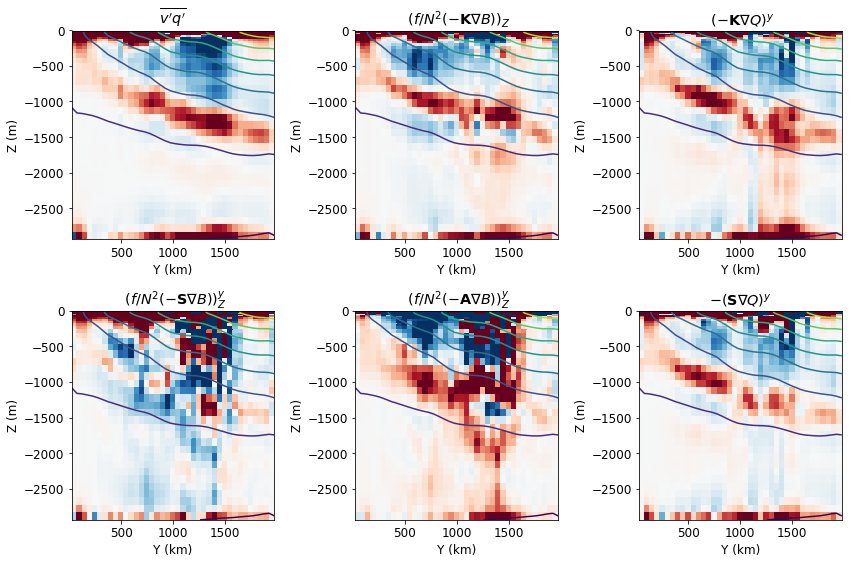

In [173]:
# y flux
fig, ax = plt.subplots(2,3,figsize=(12,8))
 
ax[0,0].pcolormesh(Ycoarse/1e3, Z, PV_flux_Vcoarse.sel(XCcoarse=1300e3, method='nearest'),
                 vmin=-0.8e-6, vmax=0.8e-6, cmap='RdBu_r',
                rasterized=True)

ax[0,0].contour(Ycoarse/1e3, Z, T_coarse['T'].sel(XCcoarse=1300e3, method='nearest'),
              levels=np.linspace(0,8,9))
ax[0,0].set_title('$\overline{v\'q\'}$ ')
ax[0,0].set_ylabel('Z (m)')
ax[0,0].set_xlabel('Y (km)')

ax[0,1].pcolormesh(Ycoarse/1e3, Z, PV_flux['vq_rec_Tflux'].sel(XCcoarse=1300e3, method='nearest'),
                 vmin=-0.8e-6, vmax=0.8e-6, cmap='RdBu_r',
                rasterized=True)
ax[0,1].contour(Ycoarse/1e3, Z, T_coarse['T'].sel(XCcoarse=1300e3, method='nearest'),
              levels=np.linspace(0,8,9))
ax[0,1].set_title(r' $(f/N^2 (-\mathbf{K} \nabla B))_Z$')
ax[0,1].set_ylabel('Z (m)')
ax[0,1].set_xlabel('Y (km)')

ax[0,2].pcolormesh(Ycoarse/1e3, Z, PV_flux['vq_Ktensor'].sel(XCcoarse=1300e3, method='nearest'), 
                      vmin=-0.8e-6, vmax=0.8e-6, cmap='RdBu_r',
                     rasterized=True)
ax[0,2].contour(Ycoarse/1e3, Z, T_coarse['T'].sel(XCcoarse=1300e3, method='nearest'),
              levels=np.linspace(0,8,9))
ax[0,2].set_title(r' $(-\mathbf{K} \nabla Q)^y$')
ax[0,2].set_ylabel('Z (m)')
ax[0,2].set_xlabel('Y (km)')

ax[1,0].pcolormesh(Ycoarse/1e3, Z, (PV_flux['vq_rec_Tflux']  -PV_flux['vq_rec_ATflux'] ).sel(XCcoarse=1300e3, method='nearest'), 
                      vmin=-0.8e-6, vmax=0.8e-6, cmap='RdBu_r',
                     rasterized=True)
ax[1,0].contour(Ycoarse/1e3, Z, T_coarse['T'].sel(XCcoarse=1300e3, method='nearest'),
              levels=np.linspace(0,8,9))
ax[1,0].set_title(r' $(f/N^2 (-\mathbf{S} \nabla B))_Z^y$')
ax[1,0].set_ylabel('Z (m)')
ax[1,0].set_xlabel('Y (km)')

ax[1,1].pcolormesh(Ycoarse/1e3, Z, PV_flux['vq_rec_ATflux'].sel(XCcoarse=1300e3, method='nearest'), 
                      vmin=-0.8e-6, vmax=0.8e-6, cmap='RdBu_r',
                     rasterized=True)
ax[1,1].contour(Ycoarse/1e3, Z, T_coarse['T'].sel(XCcoarse=1300e3, method='nearest'),
              levels=np.linspace(0,8,9))
ax[1,1].set_title(r' $(f/N^2 (-\mathbf{A} \nabla B))_Z^y$')
ax[1,1].set_ylabel('Z (m)')
ax[1,1].set_xlabel('Y (km)')


ax[1,2].pcolormesh(Ycoarse/1e3, Z, PV_flux['vq_Stensor'].sel(XCcoarse=1300e3, method='nearest'),
                 vmin=-0.8e-6, vmax=0.8e-6, cmap='RdBu_r',
                rasterized=True)
ax[1,2].contour(Ycoarse/1e3, Z, T_coarse['T'].sel(XCcoarse=1300e3, method='nearest'),
              levels=np.linspace(0,8,9))
ax[1,2].set_title(r'$-(\mathbf{S} \nabla Q)^y $')
ax[1,2].set_ylabel('Z (m)')
ax[1,2].set_xlabel('Y (km)')


plt.tight_layout()

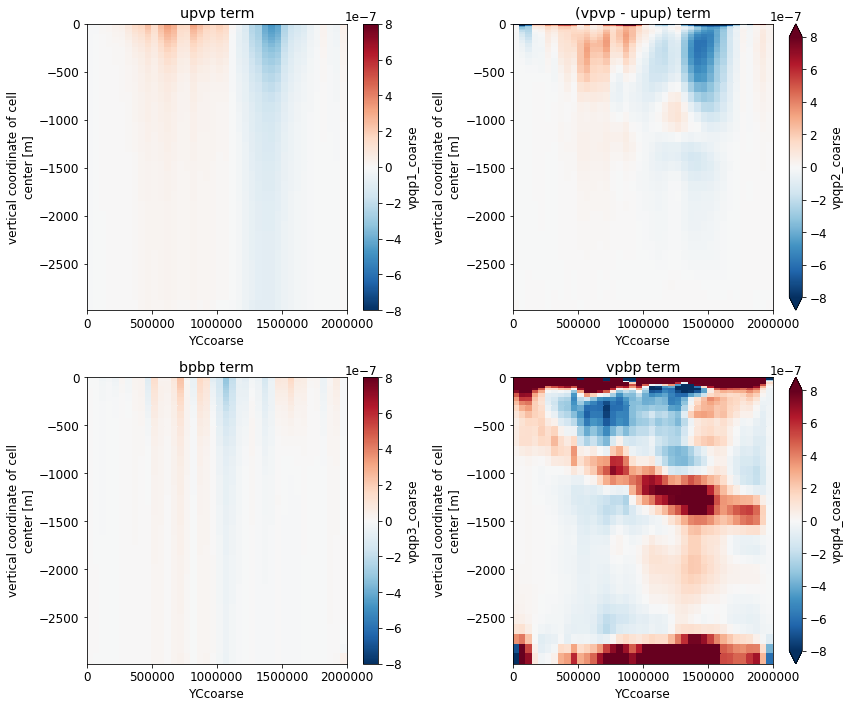

In [174]:
plt.figure(figsize=(12,10))

plt.subplot(221)
PV_fluxes_coarse['vpqp1_coarse'].sel(XCcoarse=1300e3, method='nearest').plot( vmin=-0.8e-6, vmax=0.8e-6, cmap='RdBu_r')
plt.title('upvp term')

plt.subplot(222)
PV_fluxes_coarse['vpqp2_coarse'].sel(XCcoarse=1300e3, method='nearest').plot( vmin=-0.8e-6, vmax=0.8e-6, cmap='RdBu_r')
plt.title('(vpvp - upup) term')

plt.subplot(223)
PV_fluxes_coarse['vpqp3_coarse'].sel(XCcoarse=1300e3, method='nearest').plot( vmin=-0.8e-6, vmax=0.8e-6, cmap='RdBu_r')
plt.title('bpbp term')

plt.subplot(224)
PV_fluxes_coarse['vpqp4_coarse'].sel(XCcoarse=1300e3, method='nearest').plot( vmin=-0.8e-6, vmax=0.8e-6, cmap='RdBu_r')
plt.title('vpbp term')

plt.tight_layout()

/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


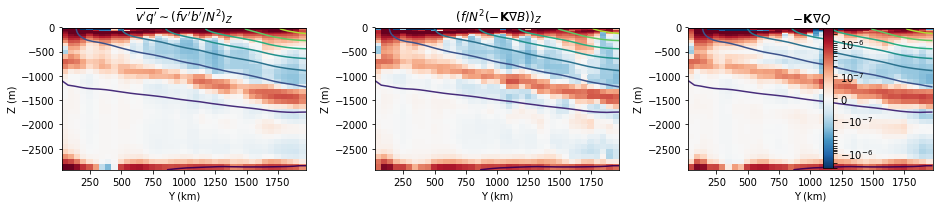

In [42]:
fig, ax = plt.subplots(1,3,figsize=(13.2,3))

ax[0].pcolormesh(Ycoarse/1e3, Z, PV_flux['vq_raw_Tflux'].sel(XCcoarse=100e3, method='nearest'),
                 vmin=-3e-6, vmax=3e-6, cmap='RdBu_r',
                rasterized=True, norm=colors.SymLogNorm(linthresh=1e-7))
ax[0].contour(Ycoarse/1e3, Z, T_coarse['T'].sel(XCcoarse=100e3, method='nearest'),
              levels=np.linspace(0,8,9))
ax[0].set_title('$\overline{v\'q\'} \sim (f \overline{v\'b\'} /N^2)_Z$ ')
ax[0].set_ylabel('Z (m)')
ax[0].set_xlabel('Y (km)')

ax[1].pcolormesh(Ycoarse/1e3, Z, PV_flux['vq_rec_Tflux'].sel(XCcoarse=100e3, method='nearest'),
                 vmin=-3e-6, vmax=3e-6, cmap='RdBu_r',
                rasterized=True, norm=colors.SymLogNorm(linthresh=1e-7))
ax[1].contour(Ycoarse/1e3, Z, T_coarse['T'].sel(XCcoarse=100e3, method='nearest'),
              levels=np.linspace(0,8,9))
ax[1].set_title(r' $(f/N^2 (-\mathbf{K} \nabla B))_Z$')
ax[1].set_ylabel('Z (m)')
ax[1].set_xlabel('Y (km)')

im = ax[2].pcolormesh(Ycoarse/1e3, Z, PV_flux['vq_Ktensor'].sel(XCcoarse=100e3, method='nearest'), 
                      vmin=-3e-6, vmax=3e-6, cmap='RdBu_r',
                     rasterized=True, norm=colors.SymLogNorm(linthresh=1e-7))
ax[2].contour(Ycoarse/1e3, Z, T_coarse['T'].sel(XCcoarse=100e3, method='nearest'),
              levels=np.linspace(0,8,9))
ax[2].set_title(r' $-\mathbf{K} \nabla Q$')
ax[2].set_ylabel('Z (m)')
ax[2].set_xlabel('Y (km)')

plt.tight_layout()

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.2, 0.01, 0.65])
fig.colorbar(im, cax=cbar_ax)

plt.tight_layout()
#plt.savefig('VQ_YZ_100km.pdf', dpi=400)

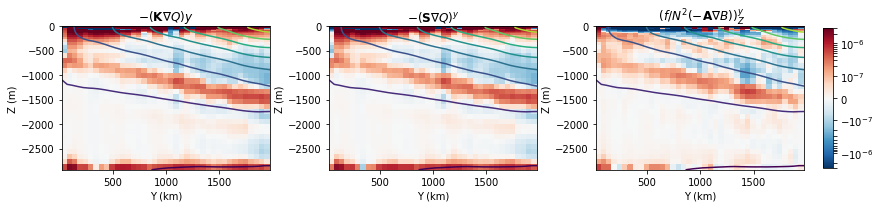

In [258]:
fig, ax = plt.subplots(1,3,figsize=(13.2,3))

ax[0].pcolormesh(Ycoarse/1e3, Z, PV_flux['vq_Ktensor'].sel(XCcoarse=100e3, method='nearest'),
                 vmin=-3e-6, vmax=3e-6, cmap='RdBu_r',
                rasterized=True, norm=colors.SymLogNorm(linthresh=1e-7))
ax[0].contour(Ycoarse/1e3, Z, T_coarse['T'].sel(XCcoarse=100e3, method='nearest'),
              levels=np.linspace(0,8,9))
ax[0].set_title(r'$-(\mathbf{K} \nabla Q)y $')
ax[0].set_ylabel('Z (m)')
ax[0].set_xlabel('Y (km)')

ax[1].pcolormesh(Ycoarse/1e3, Z, PV_flux['vq_Stensor'].sel(XCcoarse=100e3, method='nearest'),
                 vmin=-3e-6, vmax=3e-6, cmap='RdBu_r',
                rasterized=True, norm=colors.SymLogNorm(linthresh=1e-7))
ax[1].contour(Ycoarse/1e3, Z, T_coarse['T'].sel(XCcoarse=100e3, method='nearest'),
              levels=np.linspace(0,8,9))
ax[1].set_title(r'$-(\mathbf{S} \nabla Q)^y $')
ax[1].set_ylabel('Z (m)')
ax[1].set_xlabel('Y (km)')

im = ax[2].pcolormesh(Ycoarse/1e3, Z, PV_flux['vq_rec_ATflux'].sel(XCcoarse=100e3, method='nearest'), 
                      vmin=-3e-6, vmax=3e-6, cmap='RdBu_r',
                     rasterized=True, norm=colors.SymLogNorm(linthresh=1e-7))
ax[2].contour(Ycoarse/1e3, Z, T_coarse['T'].sel(XCcoarse=100e3, method='nearest'),
              levels=np.linspace(0,8,9))
ax[2].set_title(r' $(f/N^2 (-\mathbf{A} \nabla B))_Z^y$')
ax[2].set_ylabel('Z (m)')
ax[2].set_xlabel('Y (km)')

plt.tight_layout()

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.2, 0.01, 0.65])
fig.colorbar(im, cax=cbar_ax)

#plt.tight_layout()
plt.savefig('VQ_diff_tensors_YZ_100km.pdf', dpi=400)

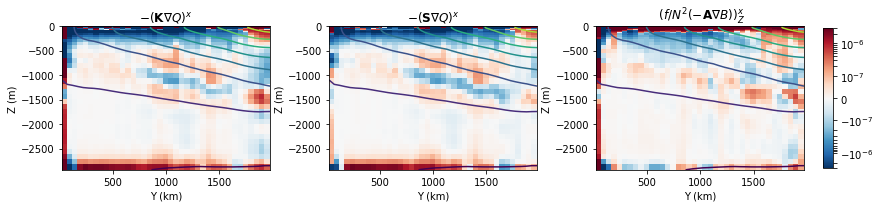

In [257]:
fig, ax = plt.subplots(1,3,figsize=(13.2,3))

ax[0].pcolormesh(Ycoarse/1e3, Z, PV_flux['uq_Ktensor'].sel(XCcoarse=100e3, method='nearest'),
                 vmin=-3e-6, vmax=3e-6, cmap='RdBu_r',
                rasterized=True, norm=colors.SymLogNorm(linthresh=1e-7))
ax[0].contour(Ycoarse/1e3, Z, T_coarse['T'].sel(XCcoarse=100e3, method='nearest'),
              levels=np.linspace(0,8,9))
ax[0].set_title(r'$-(\mathbf{K} \nabla Q)^x $')
ax[0].set_ylabel('Z (m)')
ax[0].set_xlabel('Y (km)')

ax[1].pcolormesh(Ycoarse/1e3, Z, PV_flux['uq_Stensor'].sel(XCcoarse=100e3, method='nearest'),
                 vmin=-3e-6, vmax=3e-6, cmap='RdBu_r',
                rasterized=True, norm=colors.SymLogNorm(linthresh=1e-7))
ax[1].contour(Ycoarse/1e3, Z, T_coarse['T'].sel(XCcoarse=100e3, method='nearest'),
              levels=np.linspace(0,8,9))
ax[1].set_title(r'$-(\mathbf{S} \nabla Q)^x $')
ax[1].set_ylabel('Z (m)')
ax[1].set_xlabel('Y (km)')

im = ax[2].pcolormesh(Ycoarse/1e3, Z, PV_flux['uq_rec_ATflux'].sel(XCcoarse=100e3, method='nearest'), 
                      vmin=-3e-6, vmax=3e-6, cmap='RdBu_r',
                     rasterized=True, norm=colors.SymLogNorm(linthresh=1e-7))
ax[2].contour(Ycoarse/1e3, Z, T_coarse['T'].sel(XCcoarse=100e3, method='nearest'),
              levels=np.linspace(0,8,9))
ax[2].set_title(r' $(f/N^2 (-\mathbf{A} \nabla B))_Z^x$')
ax[2].set_ylabel('Z (m)')
ax[2].set_xlabel('Y (km)')

plt.tight_layout()

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.2, 0.01, 0.65])
fig.colorbar(im, cax=cbar_ax)

#plt.tight_layout()
plt.savefig('UQ_diff_tensors_YZ_100km.pdf', dpi=400)

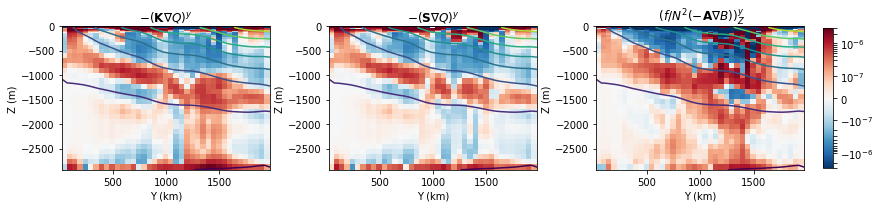

In [256]:
fig, ax = plt.subplots(1,3,figsize=(13.2,3))

ax[0].pcolormesh(Ycoarse/1e3, Z, PV_flux['vq_Ktensor'].sel(XCcoarse=1300e3, method='nearest'),
                 vmin=-3e-6, vmax=3e-6, cmap='RdBu_r',
                rasterized=True, norm=colors.SymLogNorm(linthresh=1e-7))
ax[0].contour(Ycoarse/1e3, Z, T_coarse['T'].sel(XCcoarse=1300e3, method='nearest'),
              levels=np.linspace(0,8,9))
ax[0].set_title(r'$-(\mathbf{K} \nabla Q)^y $')
ax[0].set_ylabel('Z (m)')
ax[0].set_xlabel('Y (km)')

ax[1].pcolormesh(Ycoarse/1e3, Z, PV_flux['vq_Stensor'].sel(XCcoarse=1300e3, method='nearest'),
                 vmin=-3e-6, vmax=3e-6, cmap='RdBu_r',
                rasterized=True, norm=colors.SymLogNorm(linthresh=1e-7))
ax[1].contour(Ycoarse/1e3, Z, T_coarse['T'].sel(XCcoarse=1300e3, method='nearest'),
              levels=np.linspace(0,8,9))
ax[1].set_title(r'$-(\mathbf{S} \nabla Q)^y $')
ax[1].set_ylabel('Z (m)')
ax[1].set_xlabel('Y (km)')

im = ax[2].pcolormesh(Ycoarse/1e3, Z, PV_flux['vq_rec_ATflux'].sel(XCcoarse=1300e3, method='nearest'), 
                      vmin=-3e-6, vmax=3e-6, cmap='RdBu_r',
                     rasterized=True, norm=colors.SymLogNorm(linthresh=1e-7))
ax[2].contour(Ycoarse/1e3, Z, T_coarse['T'].sel(XCcoarse=1300e3, method='nearest'),
              levels=np.linspace(0,8,9))
ax[2].set_title(r' $(f/N^2 (-\mathbf{A} \nabla B))_Z^y$')
ax[2].set_ylabel('Z (m)')
ax[2].set_xlabel('Y (km)')

plt.tight_layout()

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.2, 0.01, 0.65])
fig.colorbar(im, cax=cbar_ax)

#plt.tight_layout()
plt.savefig('VQ_diff_tensors_YZ_1300km.pdf', dpi=400)

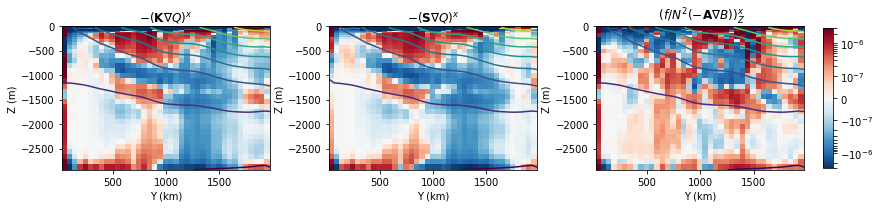

In [254]:
fig, ax = plt.subplots(1,3,figsize=(13.2,3))

ax[0].pcolormesh(Ycoarse/1e3, Z, PV_flux['uq_Ktensor'].sel(XCcoarse=1300e3, method='nearest'),
                 vmin=-3e-6, vmax=3e-6, cmap='RdBu_r',
                rasterized=True, norm=colors.SymLogNorm(linthresh=1e-7))
ax[0].contour(Ycoarse/1e3, Z, T_coarse['T'].sel(XCcoarse=1300e3, method='nearest'),
              levels=np.linspace(0,8,9))
ax[0].set_title(r'$ -(\mathbf{K} \nabla Q)^x $')
ax[0].set_ylabel('Z (m)')
ax[0].set_xlabel('Y (km)')

ax[1].pcolormesh(Ycoarse/1e3, Z, PV_flux['uq_Stensor'].sel(XCcoarse=1300e3, method='nearest'),
                 vmin=-3e-6, vmax=3e-6, cmap='RdBu_r',
                rasterized=True, norm=colors.SymLogNorm(linthresh=1e-7))
ax[1].contour(Ycoarse/1e3, Z, T_coarse['T'].sel(XCcoarse=1300e3, method='nearest'),
              levels=np.linspace(0,8,9))
ax[1].set_title(r'$-(\mathbf{S} \nabla Q)^x $')
ax[1].set_ylabel('Z (m)')
ax[1].set_xlabel('Y (km)')

im = ax[2].pcolormesh(Ycoarse/1e3, Z, PV_flux['uq_rec_ATflux'].sel(XCcoarse=1300e3, method='nearest'), 
                      vmin=-3e-6, vmax=3e-6, cmap='RdBu_r',
                     rasterized=True, norm=colors.SymLogNorm(linthresh=1e-7))
ax[2].contour(Ycoarse/1e3, Z, T_coarse['T'].sel(XCcoarse=1300e3, method='nearest'),
              levels=np.linspace(0,8,9))
ax[2].set_title(r' $(f/N^2 (-\mathbf{A} \nabla B))_Z^x$')
ax[2].set_ylabel('Z (m)')
ax[2].set_xlabel('Y (km)')

plt.tight_layout()

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.2, 0.01, 0.65])
fig.colorbar(im, cax=cbar_ax)

#plt.tight_layout()
plt.savefig('UQ_diff_tensors_YZ_1300km.pdf', dpi=400)

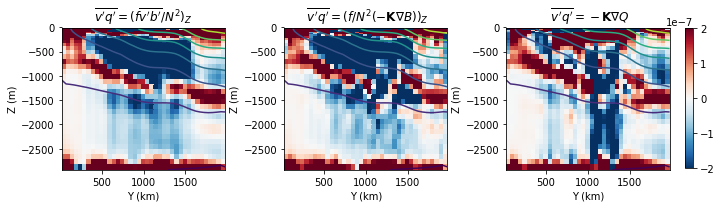

In [154]:
fig, ax = plt.subplots(1,3,figsize=(11,3))

ax[0].pcolormesh(Ycoarse/1e3, Z, PV_flux['vq_raw_Tflux'].sel(XCcoarse=1400e3, method='nearest'),
                 vmin=-2e-7, vmax=2e-7, cmap='RdBu_r',
                rasterized=True)
ax[0].contour(Ycoarse/1e3, Z, T_coarse['T'].sel(XCcoarse=1400e3, method='nearest'),
              levels=np.linspace(0,8,9))
ax[0].set_title('$\overline{v\'q\'} = (f \overline{v\'b\'} /N^2)_Z$ ')
ax[0].set_ylabel('Z (m)')
ax[0].set_xlabel('Y (km)')

ax[1].pcolormesh(Ycoarse/1e3, Z, PV_flux['vq_rec_Tflux'].sel(XCcoarse=1400e3, method='nearest'),
                 vmin=-2e-7, vmax=2e-7, cmap='RdBu_r',
                rasterized=True)
ax[1].contour(Ycoarse/1e3, Z, T_coarse['T'].sel(XCcoarse=1400e3, method='nearest'),
              levels=np.linspace(0,8,9))
ax[1].set_title(r' $\overline{v^\prime q^\prime} = (f/N^2 (-\mathbf{K} \nabla B))_Z$')
ax[1].set_ylabel('Z (m)')
ax[1].set_xlabel('Y (km)')

im = ax[2].pcolormesh(Ycoarse/1e3, Z, PV_flux['vq_Ktensor'].sel(XCcoarse=1400e3, method='nearest'), 
                      vmin=-2e-7, vmax=2e-7, cmap='RdBu_r',
                     rasterized=True)
ax[2].contour(Ycoarse/1e3, Z, T_coarse['T'].sel(XCcoarse=1400e3, method='nearest'),
              levels=np.linspace(0,8,9))
ax[2].set_title(r' $\overline{v^\prime q^\prime} = -\mathbf{K} \nabla Q$')
ax[2].set_ylabel('Z (m)')
ax[2].set_xlabel('Y (km)')

plt.tight_layout()

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.2, 0.01, 0.65])
fig.colorbar(im, cax=cbar_ax)

#plt.savefig('VQ_YZ_0km.pdf', dpi=400)

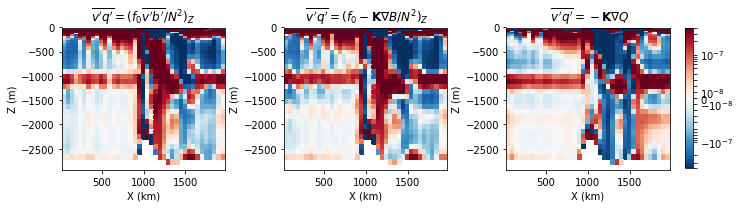

In [67]:
fig, ax = plt.subplots(1,3,figsize=(11,3))

ax[0].pcolormesh(Ycoarse/1e3, Z, vq.sel(YCcoarse=1000e3, method='nearest'), 
                 vmin=-4e-7, vmax=4e-7, cmap='RdBu_r',
                     rasterized=True, norm=colors.SymLogNorm(linthresh=5e-8))
ax[0].set_title('$\overline{v\'q\'} = (f_0 \overline{v\'b\'} /N^2)_Z$ ')
ax[0].set_ylabel('Z (m)')
ax[0].set_xlabel('X (km)')

ax[1].pcolormesh(Ycoarse/1e3, Z, vq2.sel(YCcoarse=1000e3, method='nearest'),
                 vmin=-4e-7, vmax=4e-7, cmap='RdBu_r',
                     rasterized=True, norm=colors.SymLogNorm(linthresh=5e-8))
ax[1].set_title(r' $\overline{v^\prime q^\prime} = (f_0 -\mathbf{K} \nabla B /N^2)_Z$')
ax[1].set_ylabel('Z (m)')
ax[1].set_xlabel('X (km)')

im = ax[2].pcolormesh(Ycoarse/1e3, Z, recVQ_corr.sel(YCcoarse=1000e3, method='nearest'), 
                      vmin=-4e-7, vmax=4e-7, cmap='RdBu_r',
                     rasterized=True, norm=colors.SymLogNorm(linthresh=5e-8))
ax[2].set_title(r' $\overline{v^\prime q^\prime} = -\mathbf{K} \nabla Q$')
ax[2].set_ylabel('Z (m)')
ax[2].set_xlabel('X (km)')

plt.tight_layout()

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.2, 0.01, 0.65])
fig.colorbar(im, cax=cbar_ax)

#plt.savefig('VQ_XZ_1000km.pdf', dpi=400)

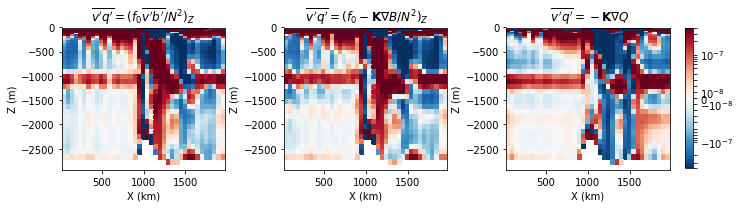

In [73]:
fig, ax = plt.subplots(1,3,figsize=(11,3))

ax[0].pcolormesh(Ycoarse/1e3, Z, vq.sel(YCcoarse=1000e3, method='nearest'), 
                 vmin=-4e-7, vmax=4e-7, cmap='RdBu_r',
                     rasterized=True, norm=colors.SymLogNorm(linthresh=5e-8))
ax[0].set_title('$\overline{v\'q\'} = (f_0 \overline{v\'b\'} /N^2)_Z$ ')
ax[0].set_ylabel('Z (m)')
ax[0].set_xlabel('X (km)')

ax[1].pcolormesh(Ycoarse/1e3, Z, vq2.sel(YCcoarse=1000e3, method='nearest'),
                 vmin=-4e-7, vmax=4e-7, cmap='RdBu_r',
                     rasterized=True, norm=colors.SymLogNorm(linthresh=5e-8))
ax[1].set_title(r' $\overline{v^\prime q^\prime} = (f_0 -\mathbf{K} \nabla B /N^2)_Z$')
ax[1].set_ylabel('Z (m)')
ax[1].set_xlabel('X (km)')

im = ax[2].pcolormesh(Ycoarse/1e3, Z, recVQ_corr.sel(YCcoarse=1000e3, method='nearest'), 
                      vmin=-4e-7, vmax=4e-7, cmap='RdBu_r',
                     rasterized=True, norm=colors.SymLogNorm(linthresh=5e-8))
ax[2].set_title(r' $\overline{v^\prime q^\prime} = -\mathbf{K} \nabla Q$')
ax[2].set_ylabel('Z (m)')
ax[2].set_xlabel('X (km)')

plt.tight_layout()

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.2, 0.01, 0.65])
fig.colorbar(im, cax=cbar_ax)

#plt.savefig('VQ_XZ_1000km.pdf', dpi=400)

In [140]:
PV_flux

<xarray.Dataset>
Dimensions:        (XCcoarse: 40, YCcoarse: 40, Z: 40)
Coordinates:
  * Z              (Z) float32 -5.0 -15.0 -25.0 ... -2727.5 -2830.5 -2933.5
  * YCcoarse       (YCcoarse) float32 25000.0 75000.0 ... 1925000.0 1975000.0
  * XCcoarse       (XCcoarse) float32 25000.0 75000.0 ... 1925000.0 1975000.0
    PHrefC         (Z) float32 49.05 147.15 245.25 ... 27767.205 28777.635
    drF            (Z) float32 10.0 10.0 10.0 12.0 ... 103.0 103.0 103.0 103.0
Data variables:
    uq_raw_Tflux   (Z, YCcoarse, XCcoarse) float32 nan nan nan ... nan nan nan
    vq_raw_Tflux   (Z, YCcoarse, XCcoarse) float32 nan nan nan ... nan nan nan
    uq_rec_Tflux   (Z, YCcoarse, XCcoarse) float32 nan nan nan ... nan nan nan
    vq_rec_Tflux   (Z, YCcoarse, XCcoarse) float32 nan nan nan ... nan nan nan
    uq_rec_ATflux  (Z, YCcoarse, XCcoarse) float32 nan nan nan ... nan nan nan
    vq_rec_ATflux  (Z, YCcoarse, XCcoarse) float32 nan nan nan ... nan nan nan
    uq_Ktensor     (Z, YCcoarse, XCcoar

Text(0, 0.5, 'Z (m)')

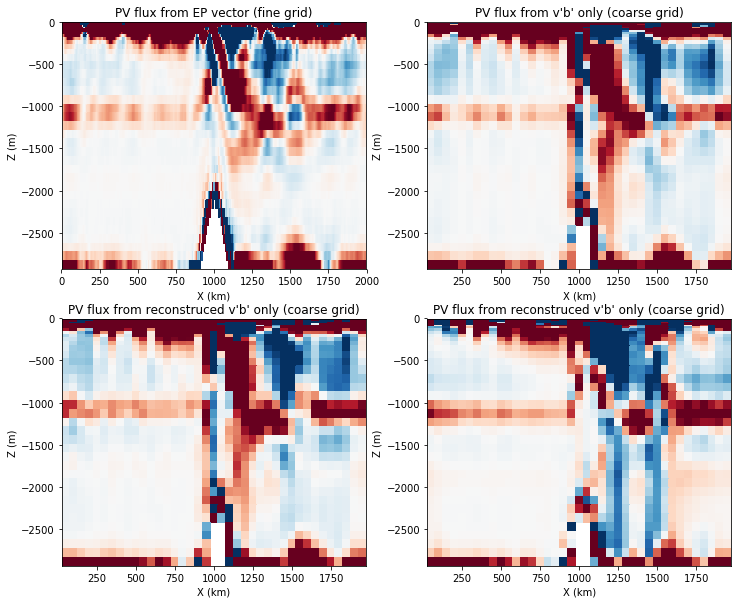

In [152]:
# Four plots Full PV flux 

fig, ax = plt.subplots(2,2, figsize=(12,10))

ax[0,0].pcolormesh(X/1e3, Z, vpqp.sel(YC=1000e3, method='nearest'),
                      vmin=-4e-7, vmax=4e-7, cmap='RdBu_r',
                     rasterized=True)
ax[0,0].set_title('PV flux from EP vector (fine grid)')
ax[0,0].set_xlabel('X (km)')
ax[0,0].set_ylabel('Z (m)')

ax[0,1].pcolormesh(Xcoarse/1e3, Z, PV_flux['vq_raw_Tflux'].sel(YCcoarse=1000e3, method='nearest'),
                      vmin=-4e-7, vmax=4e-7, cmap='RdBu_r',
                     rasterized=True)
ax[0,1].set_title('PV flux from v\'b\' only (coarse grid)')
ax[0,1].set_xlabel('X (km)')
ax[0,1].set_ylabel('Z (m)')


ax[1,0].pcolormesh(Xcoarse/1e3, Z, PV_flux['vq_rec_Tflux'].sel(YCcoarse=1000e3, method='nearest'),
                      vmin=-4e-7, vmax=4e-7, cmap='RdBu_r',
                     rasterized=True)
ax[1,0].set_title('PV flux from reconstruced v\'b\' only (coarse grid)')
ax[1,0].set_xlabel('X (km)')
ax[1,0].set_ylabel('Z (m)')

ax[1,1].pcolormesh(Xcoarse/1e3, Z, PV_flux['vq_Ktensor'].sel(YCcoarse=1000e3, method='nearest'),
                      vmin=-4e-7, vmax=4e-7, cmap='RdBu_r',
                     rasterized=True)
ax[1,1].set_title('PV flux from reconstruced v\'b\' only (coarse grid)')
ax[1,1].set_xlabel('X (km)')
ax[1,1].set_ylabel('Z (m)')


In [199]:
S_X = -T_coarse.T_X / T_coarse.T_Z
S_Y = -T_coarse.T_Y / T_coarse.T_Z

Q_y  = (beta/f0  - grid.interp(grid.diff(S_Y, 
                    'Z', boundary='extend'), 'Z', boundary='extend')/ (-T_coarse.drF))

Q_x  = (  - grid.interp(grid.diff(S_X, 
                    'Z', boundary='extend'), 'Z', boundary='extend')/ (-T_coarse.drF))

PV_x =  (diff_tensor.ST.sel(i=0, j=0)* Q_x + diff_tensor.ST.sel(i=0, j=1)* Q_y) 
PV_y =  (diff_tensor.ST.sel(i=1, j=0)* Q_x + diff_tensor.ST.sel(i=1, j=1)* Q_y) 

PV_x2 = - grid.interp(grid.diff(diff_tensor.AT.sel(i=0, j=0)*S_X + 
                              diff_tensor.AT.sel(i=0,j=1)*S_Y, 
                  'Z', boundary='extend'), 'Z', boundary='extend')/ (-T_coarse.drF)
PV_y2 = - grid.interp(grid.diff(diff_tensor.AT.sel(i=1, j=0)*S_X + 
                                diff_tensor.AT.sel(i=1,j=1)*S_Y, 
                  'Z', boundary='extend'), 'Z', boundary='extend')/ (-T_coarse.drF)

/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/xgcm/grid.py:1001: RuntimeWarning: invalid value encountered in subtract
  return data_right - data_left


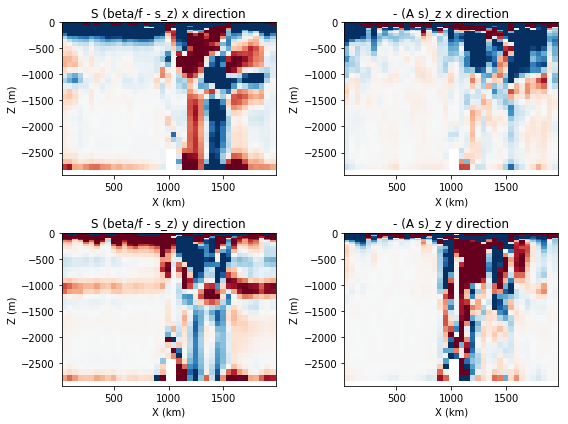

In [203]:
# Alternate method 

fig, ax = plt.subplots(2,2, figsize=(8,6))

ax[0,0].pcolormesh(Xcoarse/1e3, Z, PV_x.sel(YCcoarse=1000e3, method='nearest'),
                      vmin=-4e-3, vmax=4e-3, cmap='RdBu_r',
                     rasterized=True)
ax[0,0].set_title('S (beta/f - s_z) x direction')
ax[0,0].set_xlabel('X (km)')
ax[0,0].set_ylabel('Z (m)')

ax[0,1].pcolormesh(Xcoarse/1e3, Z, PV_x2.sel(YCcoarse=1000e3, method='nearest'),
                      vmin=-4e-3, vmax=4e-3, cmap='RdBu_r',
                     rasterized=True)
ax[0,1].set_title('- (A s)_z x direction')
ax[0,1].set_xlabel('X (km)')
ax[0,1].set_ylabel('Z (m)')

ax[1,0].pcolormesh(Xcoarse/1e3, Z, PV_y.sel(YCcoarse=1000e3, method='nearest'),
                      vmin=-4e-3, vmax=4e-3, cmap='RdBu_r',
                     rasterized=True)
ax[1,0].set_title('S (beta/f - s_z) y direction')
ax[1,0].set_xlabel('X (km)')
ax[1,0].set_ylabel('Z (m)')

ax[1,1].pcolormesh(Xcoarse/1e3, Z, PV_y2.sel(YCcoarse=1000e3, method='nearest'),
                   vmin=-4e-3, vmax=4e-3, cmap='RdBu_r',
                     rasterized=True)
ax[1,1].set_title('- (A s)_z y direction')
ax[1,1].set_xlabel('X (km)')
ax[1,1].set_ylabel('Z (m)')

plt.tight_layout()

plt.savefig('temp.pdf')

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(8,6))

ax[0,0].pcolormesh(Xcoarse/1e3, Z, PV_x.sel(YCcoarse=1000e3, method='nearest'),
                      vmin=-4e-3, vmax=4e-3, cmap='RdBu_r',
                     rasterized=True)
ax[0,0].set_title('S (beta/f - s_z) x direction')
ax[0,0].set_xlabel('X (km)')
ax[0,0].set_ylabel('Z (m)')

ax[0,1].pcolormesh(Xcoarse/1e3, Z, PV_x2.sel(YCcoarse=1000e3, method='nearest'),
                      vmin=-4e-3, vmax=4e-3, cmap='RdBu_r',
                     rasterized=True)
ax[0,1].set_title('- (A s)_z x direction')
ax[0,1].set_xlabel('X (km)')
ax[0,1].set_ylabel('Z (m)')